In [524]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
plt.rcParams['figure.figsize'] = [15,8]
import warnings
warnings.filterwarnings('ignore')

from xverse.transformer import WOE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report,f1_score,accuracy_score,cohen_kappa_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from scipy import stats


In [525]:
df=pd.read_csv("diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [526]:
print("No of rows: ",df.shape[0])
print("No of columns: ",df.shape[1])

No of rows:  101766
No of columns:  50


### Data Dictionary

Encounter ID:             Numeric : Unique identifier of an encounter

Patient number:           Numeric : Unique identifier of a patient

Race:                     Categorical: Caucasian, Asian, African American, Hispanic, and other 

Gender:                   Categorical: male, female, and unknown/invalid 

Age:                      Categorical Binned: in 10-year intervals: [0, 10), [10, 20), ..., [90, 100) 

Weight:                   Numeric Weight in pounds.

Admission type:           Nominal Categorical: 9 distinct values,1 Emergency, 2 Urgent, 3 Elective, 4 Newborn, 5 Not Available, 6 NULL, 7 Trauma Center, 8 Not Mapped

Discharge disposition:    Nominal Categorical: 29 distinct values, for example, discharged to home, expired, and not available.

Admission source:         Nominal Categorical: 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital.

Time in hospital:         Numeric Integer: number of days between admission and discharge.

Payer code:               Nominal Categorical: 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay.
                          
Medical specialty:        Specialty of the admitting physician

Num_lab_procedures:       Number of lab tests performed

Num_procedures:           Number of procedures (other than lab tests) performed

Num_medications:          Number of distinct generic names administered

Number_outpatient:        Number of outpatient visits of the patient in the year

Number_emergency:         Number of emergency visits of the patient in the year

Number_inpatient:         Number of inpatient visits of the patient in the year

diag_1:                   The primary diagnosis (coded as first three digits of ICD9)

diag_2:                   Secondary diagnosis (coded as first three digits of ICD9)

diag_3:                   Additional secondary diagnosis (coded as first three digits of ICD9)


max_glu_serum:            Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,”
“normal,” and “none” if not measured

A1Cresult:                Indicates the range of the result or if the test was not taken. Values: “>8” if the result
was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured. 


24 Features for medication: 
- Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed


metformin:                Medication used to treat type 2 diabetics 

repaglinide:              Medication used to treat type 2 diabetics       

nateglinide:              Medication used to treat type 2 diabetics             

chlorpropamide:           Medication used to treat type 2 diabetics             

glimepiride:              Medication used to treat type 2 diabetics        

acetohexamide:            Medication used to treat type 2 diabetics    

glipizide:                Medication used to treat type 2 diabetics   

glyburide:                Medication used to treat type 2 diabetics   

tolbutamide:              Medication used to treat type 2 diabetics    

pioglitazone:             Medication used to treat type 2 diabetics     

rosiglitazone:            Medication used to treat type 2 diabetics    

acarbose:                 Medication used to treat type 2 diabetics   

miglitol:                 Medication used to treat type 2 diabetics  

troglitazone:             Medication used to treat type 2 diabetics  

tolazamide:               Medication used to treat type 2 diabetics 

examide:                  Medication used to treat type 2 diabetics  

citoglipton:              Medication used to treat type 2 diabetics 

insulin:                  Medication used to treat type 2 diabetics 

glyburide-metformin:      Medication used to treat type 2 diabetics 

glipizide-metformin:      Medication used to treat type 2 diabetics  

glimepiride-pioglitazone: Medication used to treat type 2 diabetics  

metformin-rosiglitazone:  Medication used to treat type 2 diabetics  

metformin-pioglitazone:   Medication used to treat type 2 diabetics  

change:                   Indicates if there was a change in diabetic medications. Values: “change” and “no change”

diabetesMed:              Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”

readmitted:               30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no
record of readmission.

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [528]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [529]:
df.describe(include="O")

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


### Null values

In [530]:
df = df.replace(to_replace="?",value=np.nan)

In [531]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [532]:
df.isnull().sum()/len(df)*100

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.233555
gender                       0.000000
age                          0.000000
weight                      96.858479
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

In [533]:
df_cat=df.select_dtypes(include="O")
df_cat.head()

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,NaN,Pediatrics-Endocrinology,250.83,NaN,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),NaN,NaN,NaN,276,250.01,255,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),NaN,NaN,NaN,648,250,V27,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,NaN,NaN,8,250.43,403,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,NaN,NaN,197,157,250,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [534]:
df_cat.isnull().sum()/len(df_cat)*100

race                         2.233555
gender                       0.000000
age                          0.000000
weight                      96.858479
payer_code                  39.557416
medical_specialty           49.082208
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropamide               0.000000
glimepiride                  0.000000
acetohexamide                0.000000
glipizide                    0.000000
glyburide                    0.000000
tolbutamide                  0.000000
pioglitazone                 0.000000
rosiglitazone                0.000000
acarbose                     0.000000
miglitol                     0.000000
troglitazone                 0.000000
tolazamide                   0.000000
examide     

There are null values in columns

- race: 2.233% 

- weight: 96.85% 

- payer_code: 39.55% 

- medical_specialty: 49.08%

- diag_1: 0.02%

- diag_2: 0.35%

- diag_3: 1.39%

As weight, payer_code, medical_speciality have nearly 97%,40%,49% null values, treating them using any way would lead to data manipulation. Hence, we are dropping those columns

Encounter_id and patient_nbr are redundant, So dropping those also.

In [535]:
df.drop(['encounter_id','patient_nbr','weight','payer_code','medical_specialty'],1,inplace=True)

In [536]:
df.isnull().sum()

race                        2273
gender                         0
age                            0
admission_type_id              0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                        21
diag_2                       358
diag_3                      1423
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose  

In [537]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Outlier Detection

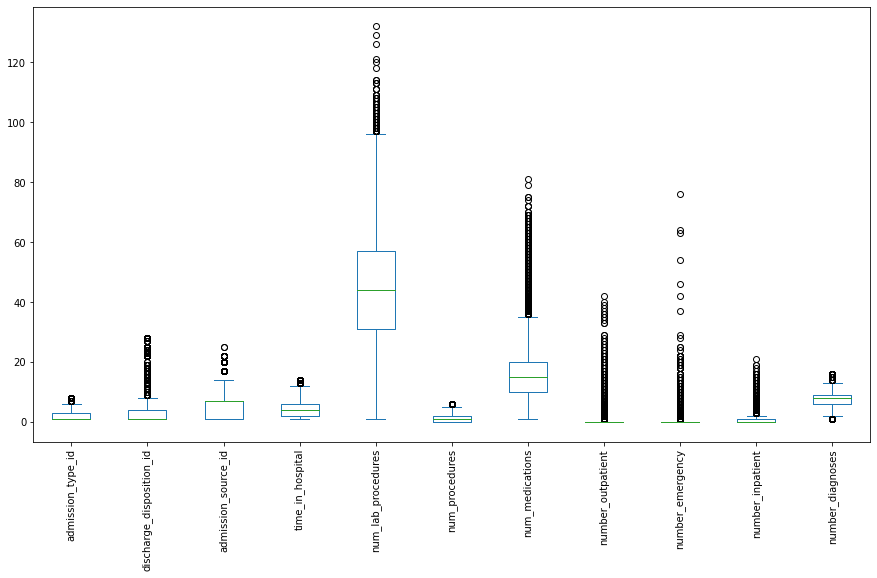

In [538]:
df.plot(kind='box')
plt.xticks(rotation=90)
plt.show()

Outliers are present in the above columns

# Data Understanding, Univariate and Bivariate Analysis

In [539]:
plt.rcParams['figure.figsize'] = [10,5]

As we want to predict if a patient will get readmitted or not:

In [540]:
df["readmitted"] = df["readmitted"].replace({"NO":0,"<30":1,">30":0})

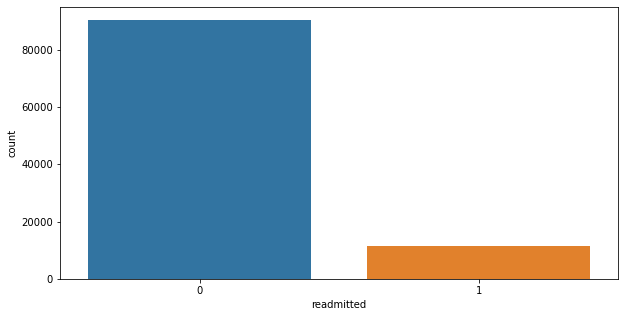

0    88.840084
1    11.159916
Name: readmitted, dtype: float64


In [541]:
sns.countplot(df['readmitted'])
plt.show()
print(df['readmitted'].value_counts(normalize=True)*100)

The classes are balanced

### Statistical Tests


In [542]:
df_cat = df.select_dtypes(include='O')

In [543]:
df_cat

,race,gender,age,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),250.83,NaN,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),276,250.01,255,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),648,250,V27,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),8,250.43,403,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),197,157,250,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),250.13,291,458,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,[80-90),560,276,787,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,[70-80),38,590,296,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,[80-90),996,285,998,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes


In [544]:
chi = pd.DataFrame(columns=['Feature','P-Value'])
for i in df_cat:
    tab = pd.crosstab(df_cat[i],df['readmitted'])
    g, p, dof, expctd = stats.chi2_contingency(tab, correction=False)
    chi = chi.append({'Feature':i , 'P-Value':round(p,3)},ignore_index=True)
chi

,Feature,P-Value
0,race,0.177
1,gender,0.539
2,age,0.000
3,diag_1,0.000
4,diag_2,0.000
5,diag_3,0.000
6,max_glu_serum,0.001
7,A1Cresult,0.000
8,metformin,0.000
9,repaglinide,0.007


In [545]:
df_num = df.select_dtypes(include=int)
df_num = df_num.iloc[:,:-1]
df_num

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,6,25,1,1,41,0,1,0,0,0,1
1,1,1,7,3,59,0,18,0,0,0,9
2,1,1,7,2,11,5,13,2,0,1,6
3,1,1,7,2,44,1,16,0,0,0,7
4,1,1,7,1,51,0,8,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
101761,1,3,7,3,51,0,16,0,0,0,9
101762,1,4,5,5,33,3,18,0,0,1,9
101763,1,1,7,1,53,0,9,1,0,0,13
101764,2,3,7,10,45,2,21,0,0,1,9


In [546]:
for i in df_num:
    print(stats.shapiro(df_num[i]))

ShapiroResult(statistic=0.721352219581604, pvalue=0.0)
ShapiroResult(statistic=0.5689888000488281, pvalue=0.0)
ShapiroResult(statistic=0.7370086908340454, pvalue=0.0)
ShapiroResult(statistic=0.8869138360023499, pvalue=0.0)
ShapiroResult(statistic=0.9848397970199585, pvalue=0.0)
ShapiroResult(statistic=0.7740449905395508, pvalue=0.0)
ShapiroResult(statistic=0.9244065880775452, pvalue=0.0)
ShapiroResult(statistic=0.3123285174369812, pvalue=0.0)
ShapiroResult(statistic=0.19770395755767822, pvalue=0.0)
ShapiroResult(statistic=0.5557276010513306, pvalue=0.0)
ShapiroResult(statistic=0.8045727014541626, pvalue=0.0)


In [547]:
kruskal = pd.DataFrame(columns=['Feature','P-Value'])
for i in df_num:
    grp1 = df_num[df['readmitted'] == 0][i] 
    grp2 = df_num[df['readmitted'] == 1][i] 
    f,p = stats.kruskal(grp1,grp2)
    kruskal = kruskal.append({'Feature':i , 'P-Value':round(p,3)},ignore_index=True)
kruskal

,Feature,P-Value
0,admission_type_id,0.000
1,discharge_disposition_id,0.000
2,admission_source_id,0.000
3,time_in_hospital,0.000
4,num_lab_procedures,0.000
5,num_procedures,0.051
6,num_medications,0.000
7,number_outpatient,0.000
8,number_emergency,0.000
9,number_inpatient,0.000


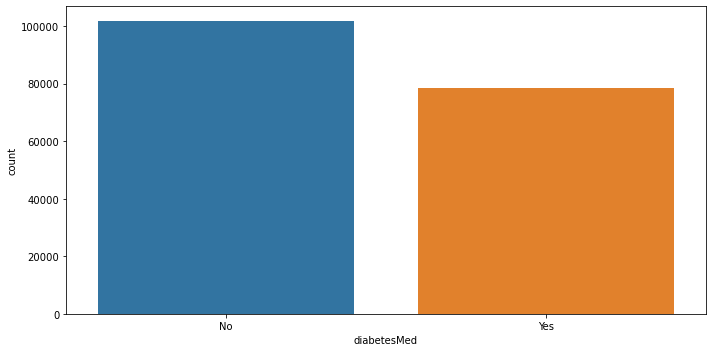

In [548]:
for i in df_cat:
    sns.countplot(df_cat[i])
plt.tight_layout()
plt.show()

#### Race

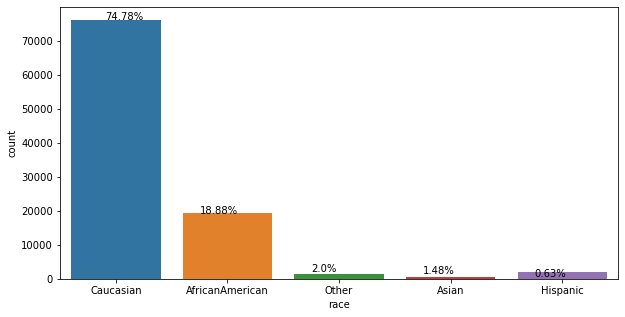

In [549]:
sns.countplot(df_cat["race"])
plt.text(x = -0.1, y = df_cat["race"].value_counts()[0] + 1,
         s = str(round((df_cat["race"].value_counts()[0])*100/len(df_cat),2)) + '%')
plt.text(x = 0.75, y = df_cat["race"].value_counts()[1] +1,
         s = str(round((df_cat["race"].value_counts()[1])*100/len(df_cat),2)) + '%')
plt.text(x =1.75, y = df_cat["race"].value_counts()[2] +1,
         s = str(round((df_cat["race"].value_counts()[2])*100/len(df_cat),2)) + '%')
plt.text(x = 2.75, y = df_cat["race"].value_counts()[3] +1,
         s = str(round((df_cat["race"].value_counts()[3])*100/len(df_cat),2)) + '%')
plt.text(x =3.75, y = df_cat["race"].value_counts()[4] +1,
         s = str(round((df_cat["race"].value_counts()[4])*100/len(df_cat),2)) + '%')
plt.show()

In [550]:
df_cat["race"].value_counts()/len(df_cat)*100

Caucasian          74.778413
AfricanAmerican    18.876639
Hispanic            2.001651
Other               1.479866
Asian               0.629876
Name: race, dtype: float64

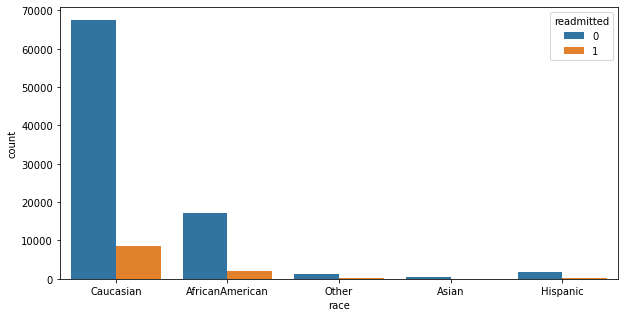

In [551]:
sns.countplot(df_cat["race"],hue=df["readmitted"])
plt.show()

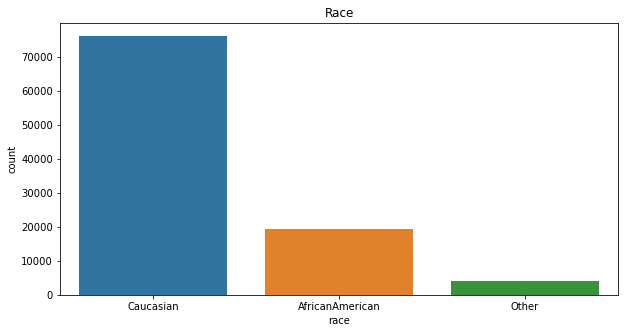

Percent of Race After Mapping
Caucasian          76.486788
AfricanAmerican    19.307891
Other               4.205321
Name: race, dtype: float64


In [552]:
df_cat["race"] = df_cat["race"].replace(["Asian","Hispanic"],"Other")
sns.countplot(df_cat['race'])
plt.title("Race")
plt.show()
print("Percent of Race After Mapping")
print(df_cat["race"].value_counts(normalize= True)*100)

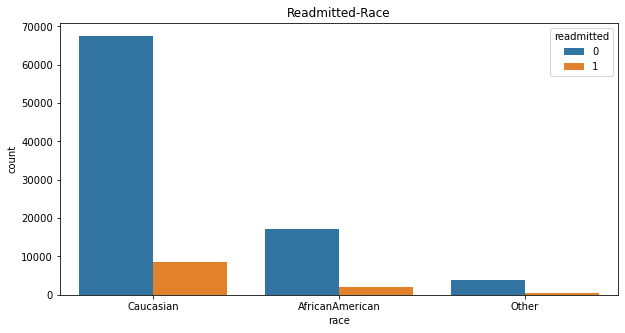

In [553]:
sns.countplot(df_cat["race"], hue= df["readmitted"])
plt.title("Readmitted-Race")
plt.show()

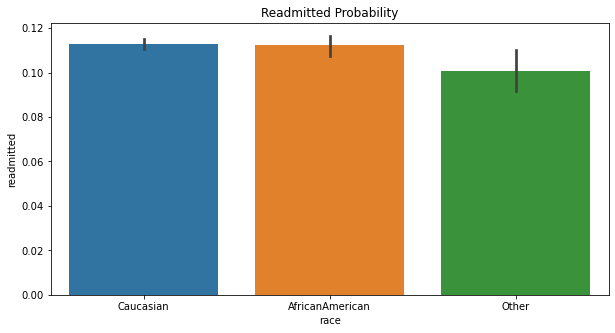

In [554]:
sns.barplot(df_cat["race"],df["readmitted"])
plt.title("Readmitted Probability")
plt.show()

 Most of the patients are from Caucasian with African Americans following.
 
 Even though other values are less than Caucasian,the Readmission Probability is close to Caucasian

#### Gender column

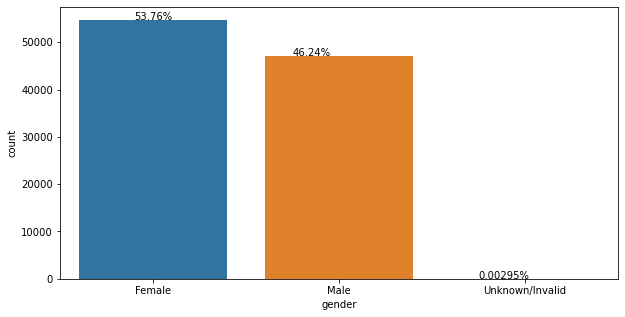

In [555]:
sns.countplot(df_cat["gender"])
plt.text(x = -0.1, y = df_cat["gender"].value_counts()[0] + 1,
         s = str(round((df_cat["gender"].value_counts()[0])*100/len(df_cat),2)) + '%')
plt.text(x = 0.75, y = df_cat["gender"].value_counts()[1] +1,
         s = str(round((df_cat["gender"].value_counts()[1])*100/len(df_cat),2)) + '%')
plt.text(x =1.75, y = df_cat["gender"].value_counts()[2] +1,
         s = str(round((df_cat["gender"].value_counts()[2])*100/len(df_cat),5)) + '%')
plt.show()

In [556]:
df_cat["gender"].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

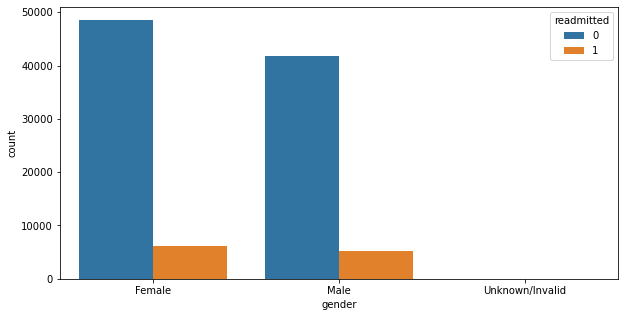

In [557]:
sns.countplot(df_cat["gender"],hue=df["readmitted"])
plt.show()

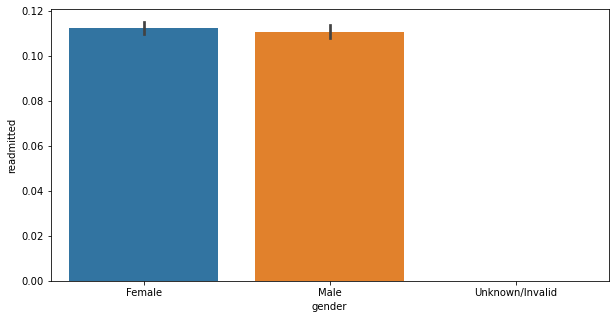

In [558]:
sns.barplot(x = df_cat["gender"],y = df["readmitted"])
plt.show()

Gender is almost equally distributed.

Readmission probability is slightly higher for Females than Males

#### Age

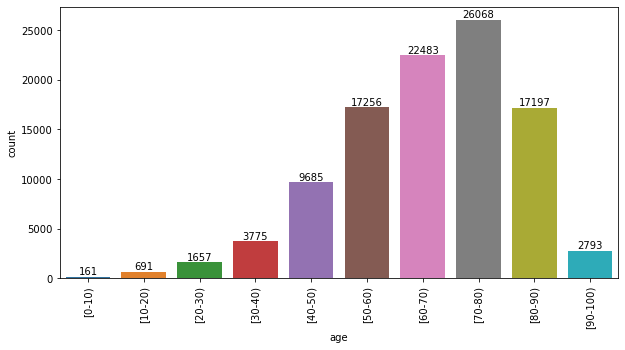

In [559]:
ax = sns.countplot(df_cat["age"])
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation = 90)
plt.show()

In [560]:
df_cat["age"].value_counts()/len(df_cat)*100

[70-80)     25.615628
[60-70)     22.092840
[50-60)     16.956547
[80-90)     16.898571
[40-50)      9.516931
[30-40)      3.709490
[90-100)     2.744532
[20-30)      1.628245
[10-20)      0.679009
[0-10)       0.158206
Name: age, dtype: float64

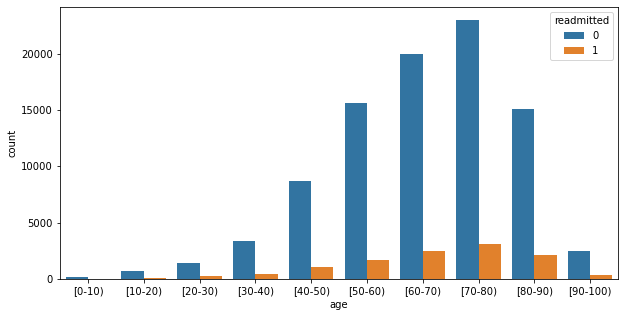

In [561]:
sns.countplot(df_cat["age"],hue=df["readmitted"])
plt.show()

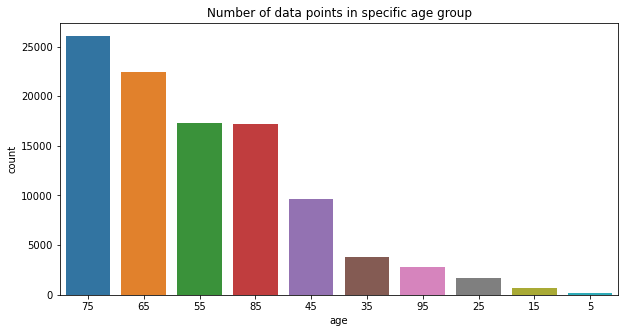

In [562]:
df_cat["age"]=df_cat["age"].replace({"[70-80)":75,
                         "[60-70)":65,
                         "[50-60)":55,
                         "[80-90)":85,
                         "[40-50)":45,
                         "[30-40)":35,
                         "[90-100)":95,
                         "[20-30)":25,
                         "[10-20)":15,
                         "[0-10)":5})

sns.countplot(df_cat["age"],order =df_cat["age"].value_counts().index)
plt.title('Number of data points in specific age group')
plt.show()

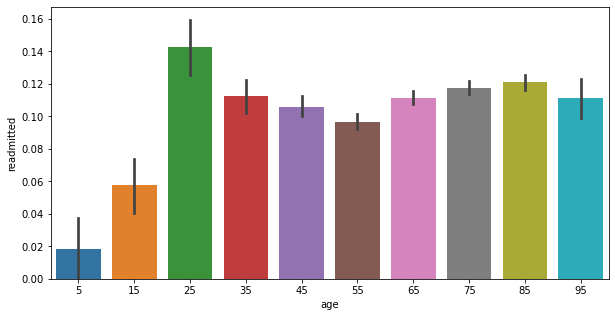

In [563]:
sns.barplot(df_cat["age"],df["readmitted"])
plt.show()

The highest number of patients are from age groups 70-80, 60-70 and 50-60 in the same order

elderly age group has more readmission probability than other groups

#### admission_type_id 

admission_type_id description

1   : Emergency
2   : Urgent
3   : Elective
4   : Newborn
5   : Not Available
6   : NULL
7   : Trauma Center
8   : Not Mapped


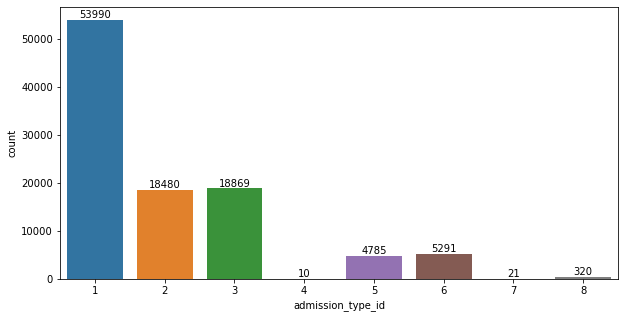

In [564]:
ax = sns.countplot(df["admission_type_id"])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

In [565]:
mapped = {1.0:"Emergency",
          2.0:"Emergency",
          3.0:"Elective",
          4.0:"New Born",
          5.0:np.nan,
          6.0:np.nan,
          7.0:"Trauma Center",
          8.0:np.nan}

In [566]:
df["admission_type_id"]=df["admission_type_id"].replace(mapped)

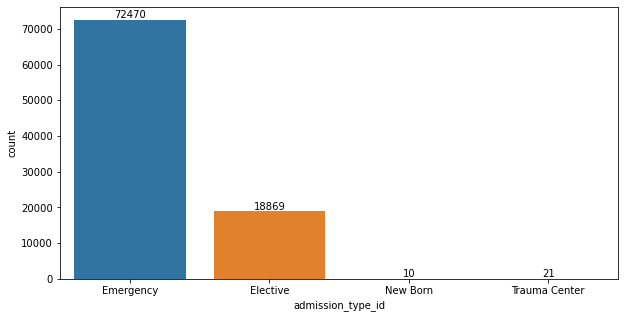

In [567]:
ax = sns.countplot(df["admission_type_id"])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

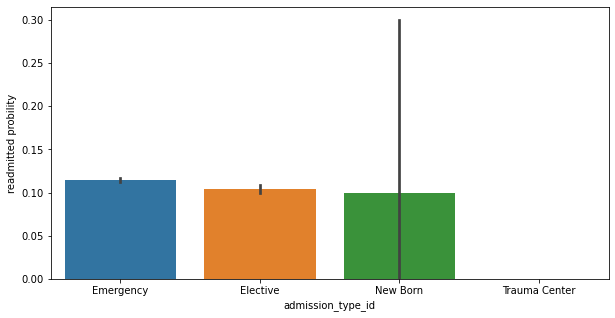

In [568]:
sns.barplot(df["admission_type_id"],df["readmitted"])
plt.ylabel("readmitted probility")
plt.show()

Emergency is the highest admission type

Readmission probability is higher for Emergency followed by elective

#### discharge_disposition_id

1.	Discharged to home
2.	Discharged/transferred to another short term hospital
3.	Discharged/transferred to SNF
4.	Discharged/transferred to ICF
5.	Discharged/transferred to another type of inpatient care institution
6.	Discharged/transferred to home with home health service
7.	Left AMA
8.	Discharged/transferred to home under care of Home IV provider
9.	Admitted as an inpatient to this hospital
10.	Neonate discharged to another hospital for neonatal aftercare
11. Expired
12.	Still patient or expected to return for outpatient services
13. Hospice / home
14.	Hospice / medical facility
15.	Discharged/transferred within this institution to Medicare approved swing bed
16.	Discharged/transferred/referred another institution for outpatient services
17.	Discharged/transferred/referred to this institution for outpatient services
18.	NULL
19.	Expired at home. Medicaid only, hospice.
20.	Expired in a medical facility. Medicaid only, hospice.
21.	Expired, place unknown. Medicaid only, hospice.
22.	Discharged/transferred to another rehab fac including rehab units of a hospital .
23.	Discharged/transferred to a long term care hospital.
24.	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25.	Not Mapped
26.	Unknown/Invalid
27.	Discharged/transferred to a federal health care facility.
28.	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29.	Discharged/transferred to a Critical Access Hospital (CAH)
30.	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere

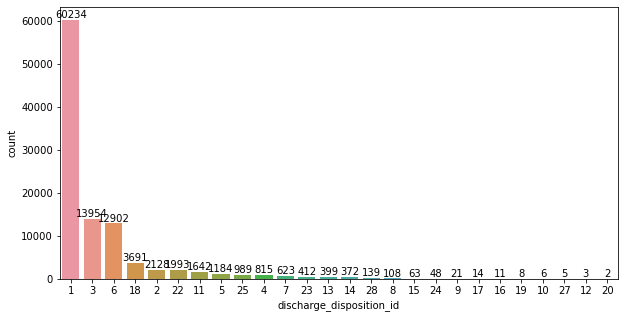

In [569]:
ax = sns.countplot(df["discharge_disposition_id"],order=df["discharge_disposition_id"].value_counts().index)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

In [570]:
df["discharge_disposition_id"].value_counts()/len(df)*100

1     59.188727
3     13.711849
6     12.678105
18     3.626948
2      2.091072
22     1.958414
11     1.613505
5      1.163453
25     0.971837
4      0.800857
7      0.612189
23     0.404850
13     0.392076
14     0.365544
28     0.136588
8      0.106126
15     0.061907
24     0.047167
9      0.020636
17     0.013757
16     0.010809
19     0.007861
10     0.005896
27     0.004913
12     0.002948
20     0.001965
Name: discharge_disposition_id, dtype: float64

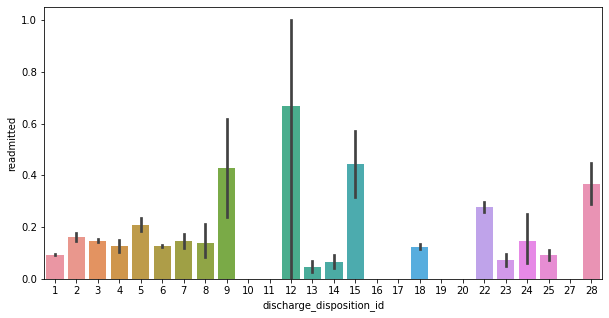

In [571]:
sns.barplot(df["discharge_disposition_id"],df["readmitted"])
plt.show()

- Discharged to home
- Discharged/transferred to SNF
- Discharged/transferred to home with home health service

are most frequent types of discharge disposition ID

- Discharged/transferred within this institution to Medicare approved swing bed
- Neonate discharged to another hospital for neonatal aftercare
- Still patient or expected to return for outpatient services

have higher Readmission probability

#### Admission Source ID

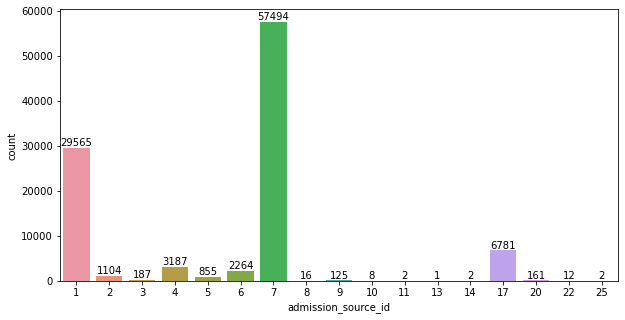

In [572]:
ax = sns.countplot(df["admission_source_id"])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

Replacing the Null, Not Mapped, Unknown values as NAN and similar with other and referral

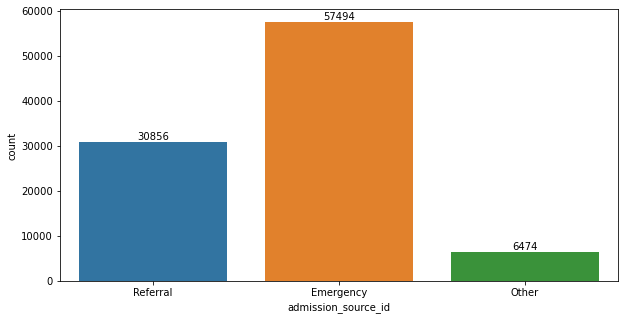

In [573]:
adm = {1:"Referral",2:"Referral",3:"Referral",4:"Other",5:"Other",6:"Other",10:"Other",22:"Other",25:"Other",9:"Other",8:"Other",14:"Other",13:"Other",11:"Other",15:np.nan,17:np.nan,20:np.nan,21:np.nan,7:"Emergency"}
df.admission_source_id = df.admission_source_id.replace(adm)
ax = sns.countplot(df["admission_source_id"])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

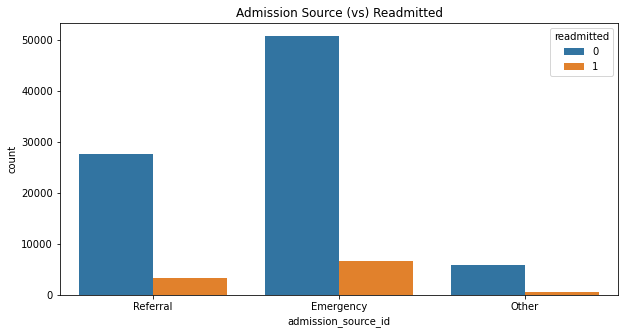

In [574]:
sns.countplot(x = df["admission_source_id"], hue = df["readmitted"])
plt.title("Admission Source (vs) Readmitted")
plt.show()

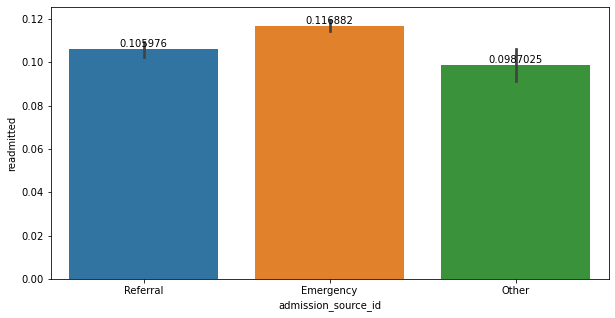

In [575]:
ax = sns.barplot(df["admission_source_id"],df["readmitted"])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

The type of admission source is highest for Emergency followed by referral

Readmission probability is highest for Emergency

The probability of Referral is very close to Emergency.

#### Time_in_hospital

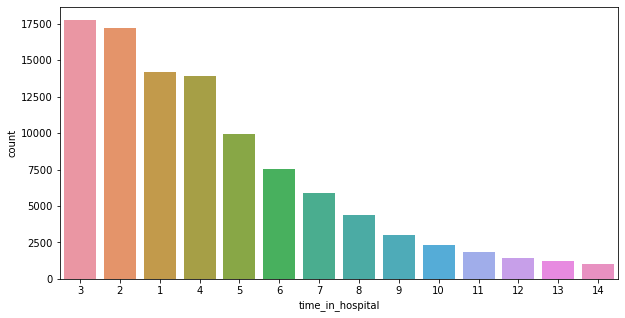

In [576]:
sns.countplot(df["time_in_hospital"],order=df["time_in_hospital"].value_counts().index)
plt.show()

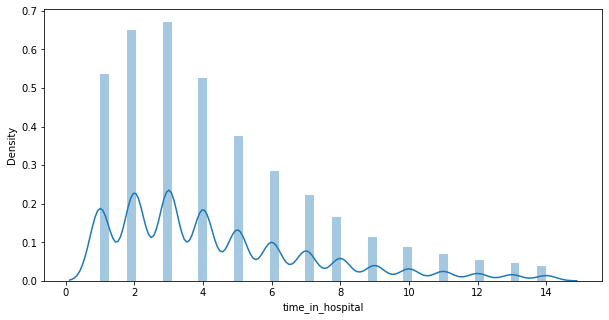

In [577]:
sns.distplot(df["time_in_hospital"])
plt.show()

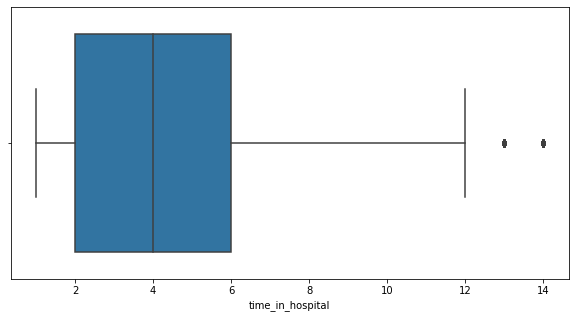

In [578]:
sns.boxplot(df["time_in_hospital"])
plt.show()

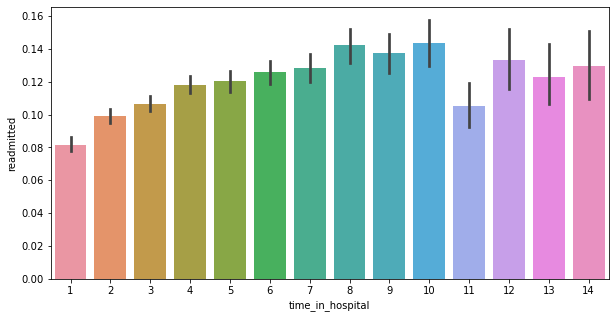

In [579]:
sns.barplot(df["time_in_hospital"],df["readmitted"])
plt.show()

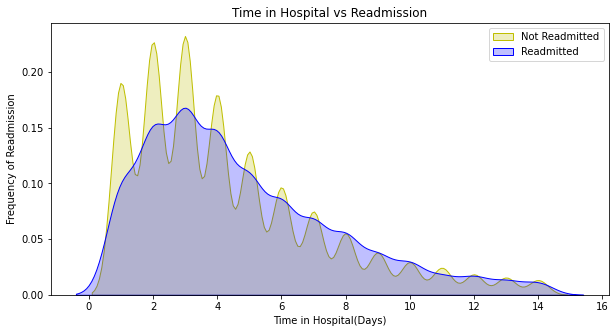

In [580]:
fig = plt.figure(figsize=(10,5))
a= sns.kdeplot(df.loc[(df.readmitted == 0), "time_in_hospital"],color = "y", shade = True, label = "Not Readmitted")
a= sns.kdeplot(df.loc[(df.readmitted == 1), "time_in_hospital"],color = "b", shade = True, label = "Readmitted")
a.legend(loc="upper right")
a.set_xlabel("Time in Hospital(Days)")
a.set_ylabel("Frequency of Readmission")
a.set_title("Time in Hospital vs Readmission")
plt.show()

People mostly stayed  2 to 3 days in hospital

### Num_lab_procedures

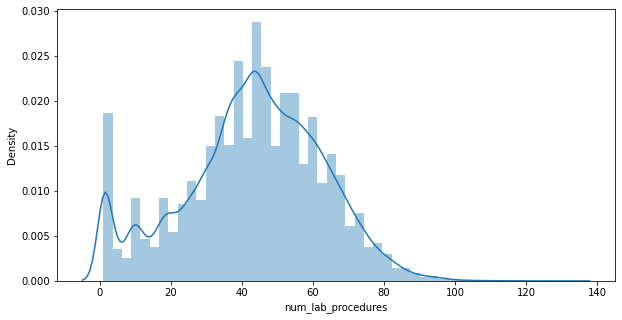

In [581]:
sns.distplot(df['num_lab_procedures'])
plt.show()

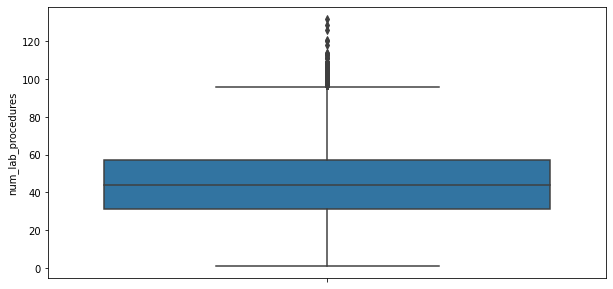

In [582]:
sns.boxplot(y=df['num_lab_procedures'])
plt.show()

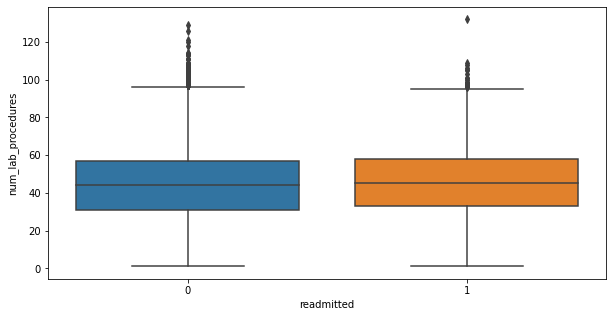

In [583]:
sns.boxplot(y=df['num_lab_procedures'],x=df['readmitted'])
plt.show()

The most number of lab procedures are in the range 35 to 60

Number of lab procedures is slightly higher for readmitted than for not readmitted patients

### Num_of_procedures

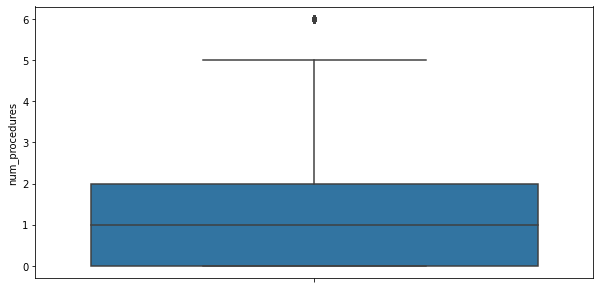

In [584]:
sns.boxplot(y=df['num_procedures'])
plt.show()

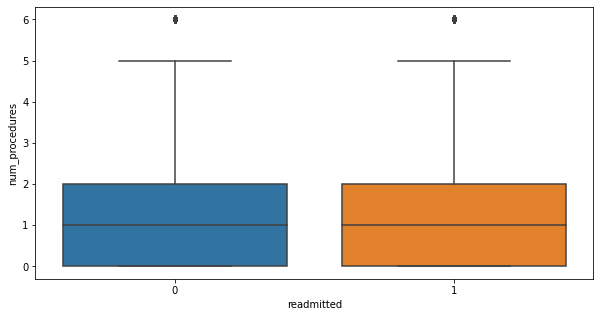

In [585]:
sns.boxplot(x=df['readmitted'],y=df['num_procedures'])
plt.show()

Most number of procedures are in the range 0 to 2

Number of procedures is almost the same for both readmitted and not readmitted patients

### Num_of_medications

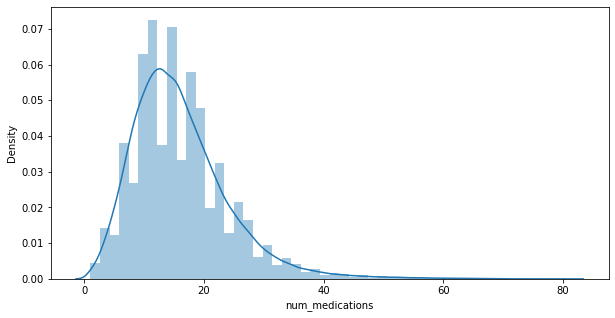

In [586]:
sns.distplot(df['num_medications'])
plt.show()

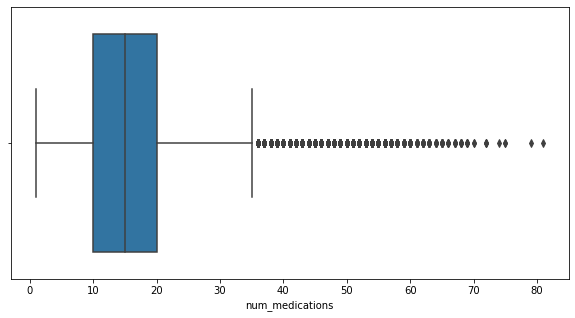

In [587]:
sns.boxplot(df['num_medications'])
plt.show()

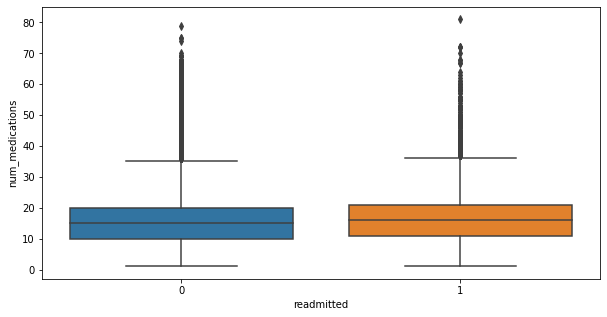

In [588]:
sns.boxplot(y=df['num_medications'],x=df['readmitted'])
plt.show()

Most number of medications are in the range of 10 to 20

Number of medications is slightly higher for readmitted than for not readmitted patients

### Num_outpatient

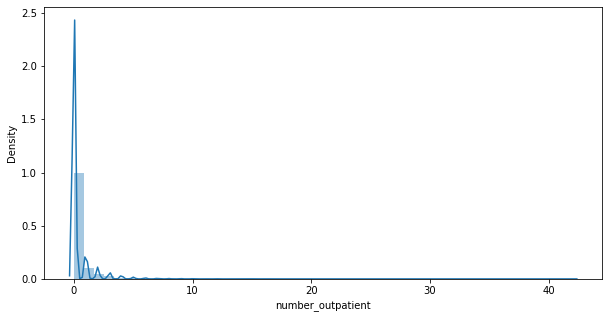

In [589]:
sns.distplot(df['number_outpatient'])
plt.show()

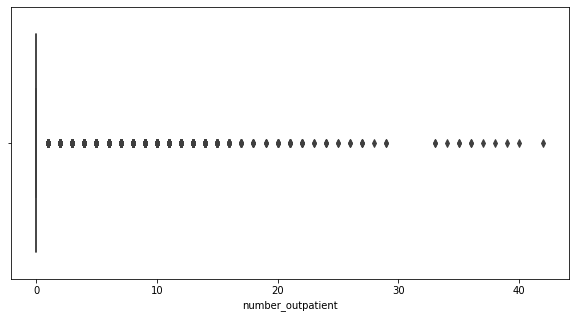

In [590]:
sns.boxplot(df['number_outpatient'])
plt.show()

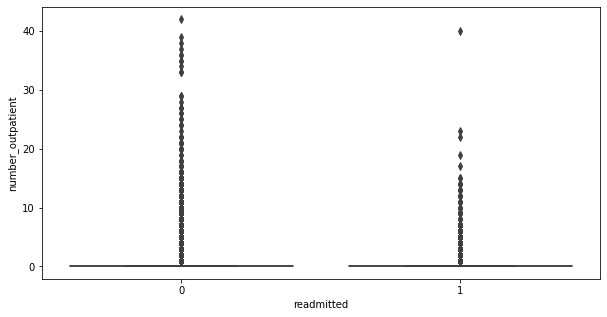

In [591]:
sns.boxplot(y=df['number_outpatient'],x=df['readmitted'])
plt.show()

Most number of outpatient visits are 0

There are many outliers in this feature

### Num_emergency

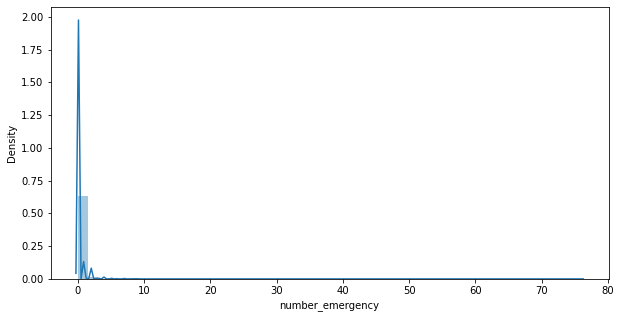

In [592]:
sns.distplot(df['number_emergency'])
plt.show()

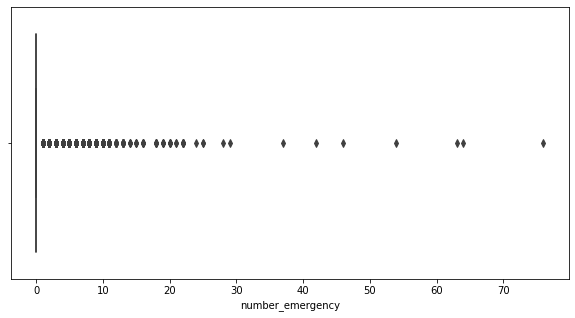

In [593]:
sns.boxplot(df['number_emergency'])
plt.show()

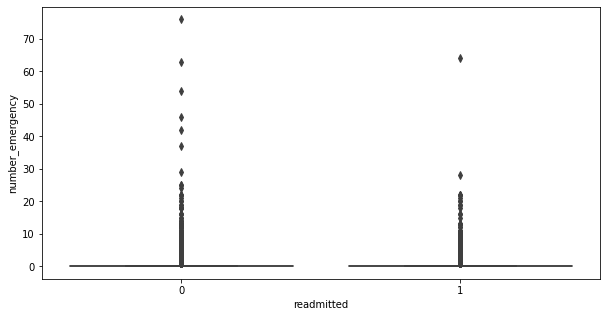

In [594]:
sns.boxplot(y=df['number_emergency'],x=df['readmitted'])
plt.show()

Most number of emergency visits are 0

There are many outliers in this feature

### Num_inpatient

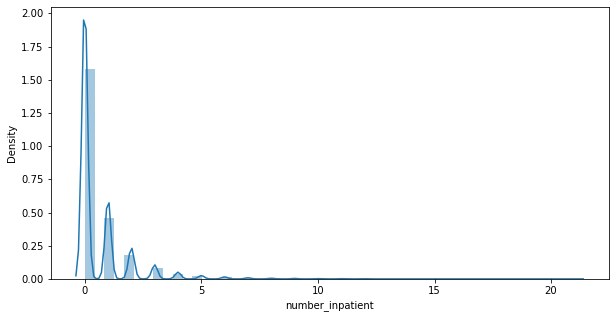

In [595]:
sns.distplot(df['number_inpatient'])
plt.show()

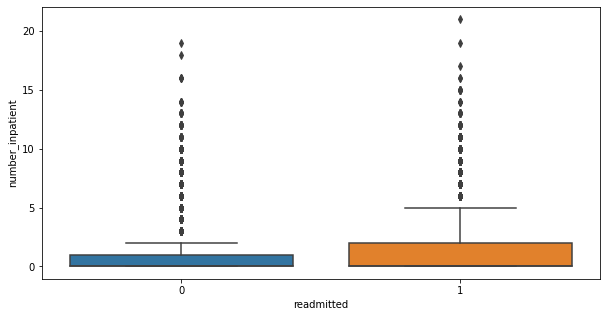

In [596]:
sns.boxplot(y=df['number_inpatient'],x=df['readmitted'])
plt.show()

Most number of inpatient visits are in the order 0, 1, 2, 3

For readmitted patients the most number of inpatient visits are in either 0 or 1 and for not readmitted they are mostly 0

### diag_1, diag_2, diag_3

In [597]:
def diagmap(data, cols):
    for col in cols:
        data.loc[(data[col].str.contains("V")) | (data[col].str.contains("E")), col] = -1
        data[col] = data[col].astype(np.float16)

    for col in cols:
        data["temp_diag"] = np.nan
        data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
        data.loc[(data[col]>=460) & (data[col]<=519) | (data[col]==786), "temp_diag"] = "Respiratory"
        data.loc[(data[col]>=520) & (data[col]<=579) | (data[col]==787), "temp_diag"] = "Digestive"
        data.loc[(data[col]>=250) & (data[col]<251), "temp_diag"] = "Diabetes"
        data.loc[(data[col]>=800) & (data[col]<=999), "temp_diag"] = "Injury"
        data.loc[(data[col]>=710) & (data[col]<=739), "temp_diag"] = "Muscoloskeletal"
        data.loc[(data[col]>=580) & (data[col]<=629) | (data[col] == 788), "temp_diag"] = "Genitourinary"
        data.loc[(data[col]>=140) & (data[col]<=239), "temp_diag"] = "Neoplasms"

        data["temp_diag"] = data["temp_diag"].fillna("Other")
        data[col] = data["temp_diag"]
        data = data.drop("temp_diag", axis=1)

    return data

In [598]:
df = diagmap(df,["diag_1","diag_2","diag_3"])

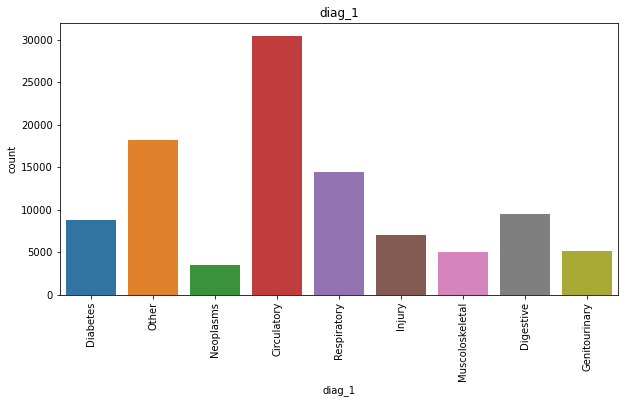

In [599]:
sns.countplot(df['diag_1'])
plt.xticks(rotation = 90)
plt.title('diag_1')
plt.show()

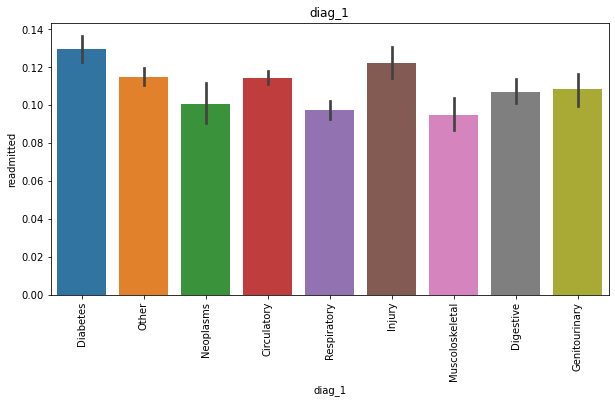

In [600]:
sns.barplot(x=df['diag_1'],y=df['readmitted'])
plt.xticks(rotation = 90)
plt.title('diag_1')
plt.show()

Circulatory, Respiratory and other types are highest in number in primary diagnosis

Readmission probability is highest for Diabetes, respiratory and circulatory

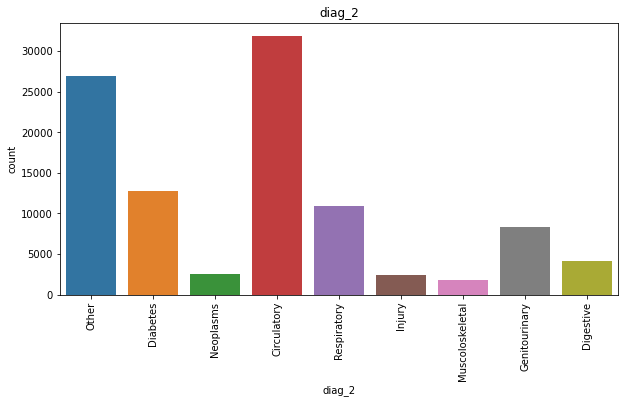

In [601]:
sns.countplot(df['diag_2'])
plt.xticks(rotation = 90)
plt.title('diag_2')
plt.show()

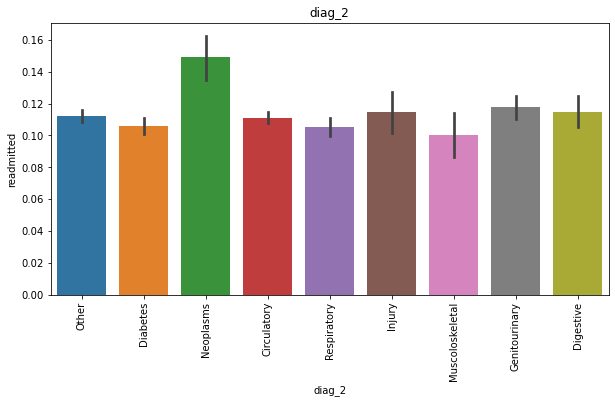

In [602]:
sns.barplot(x=df['diag_2'],y=df['readmitted'])
plt.xticks(rotation = 90)
plt.title('diag_2')
plt.show()

Circulatory, other types and diabetes are highest in number in secondary diagnosis

Readmission probability is highest for Genitourinary, respiratory and circulatory

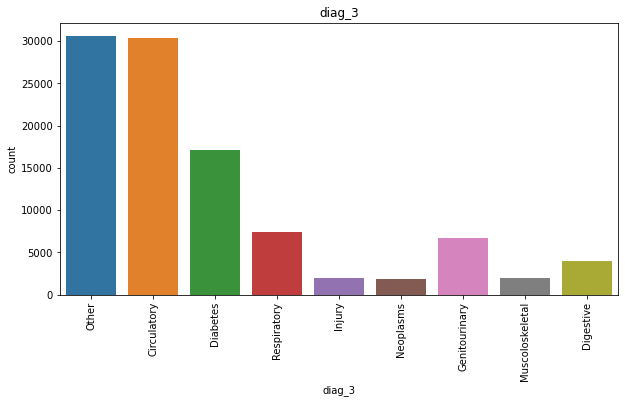

In [603]:
sns.countplot(df['diag_3'])
plt.xticks(rotation = 90)
plt.title('diag_3')
plt.show()

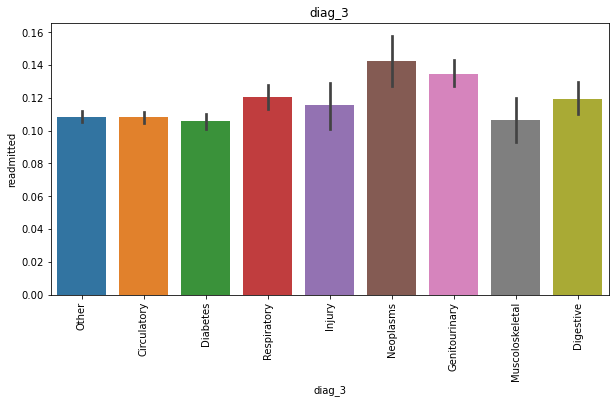

In [604]:
sns.barplot(x=df['diag_3'],y=df['readmitted'])
plt.xticks(rotation = 90)
plt.title('diag_3')
plt.show()

Circulatory, Other types and diabetes are highest in number in Tertiary diagnosis

Readmission probability is highest for Genitourinary, diabetes and digestive

#### Num of diagnoses

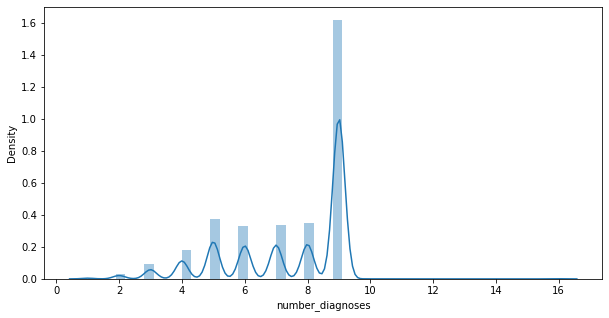

In [605]:
sns.distplot(df['number_diagnoses'])
plt.show()

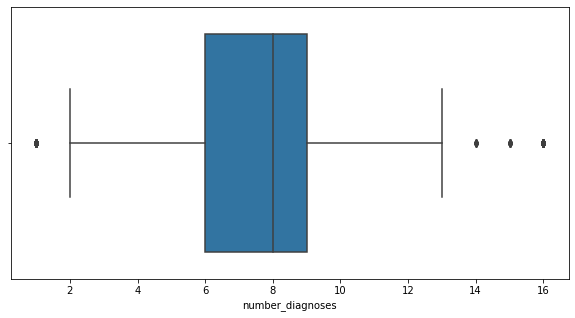

In [606]:
sns.boxplot(df['number_diagnoses'])
plt.show()

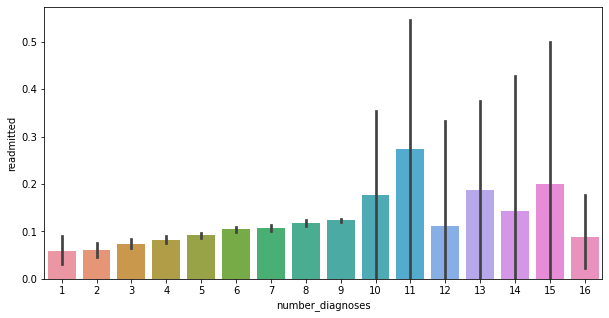

In [607]:
sns.barplot(df['number_diagnoses'],df['readmitted'])
plt.show()

Most of the number of diagnosis are between 6 to 9

Highest number of diagnosis is 9

Readmission probability is highest for higher number of diagnosis

#### max_glu_serum

- The glucose serum is the simplest and most direct single test available to test for diabetes. 

- The test measures the amount of glucose in the fluid portion of the blood

- Indicates the range of the result or if the test was not taken. 

- Values: >200, >300, normal, and none if not measured

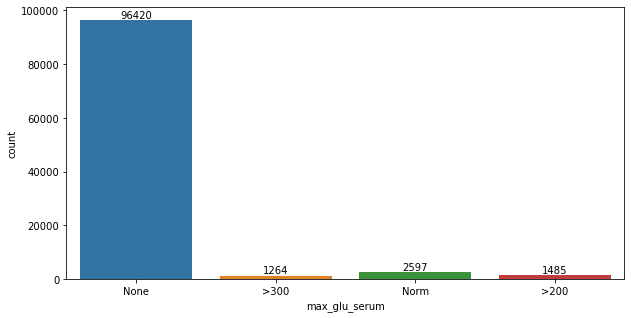

In [608]:
ax = sns.countplot(df['max_glu_serum'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

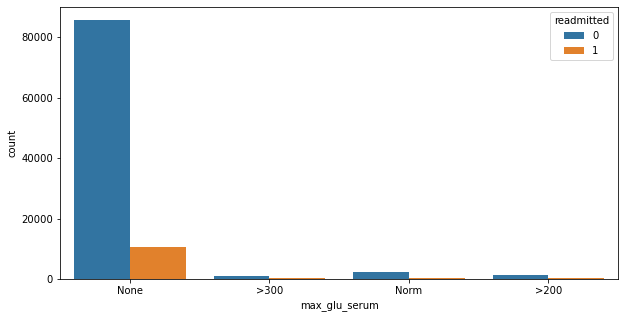

In [609]:
sns.countplot(df['max_glu_serum'],hue=df['readmitted'])
plt.show()

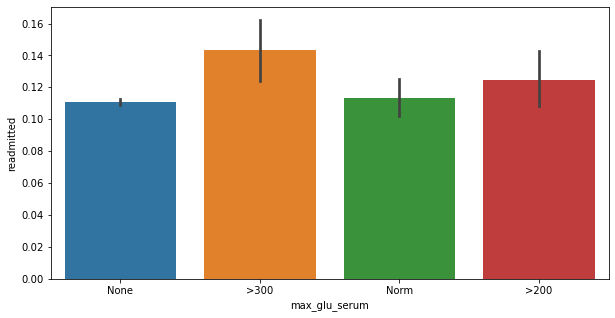

In [610]:
sns.barplot(df['max_glu_serum'],df['readmitted'])
plt.show()

For most of the patients Glucose serum test was not conducted

Results were normal for most of the patients follwed by >200 and then >300

Readmission probability was highest for patients with test results >300 and >200

#### A1Cresult

- It is simple blood test that measures your average blood sugar levels over the past 3 months

- Indicates the range of the result or if the test was not taken. 

- Values: >8 if the result was greater than 8% , >7 if the result was greater than 7% but less than 8%, normal if the result was less than 7%, and none if not measured.

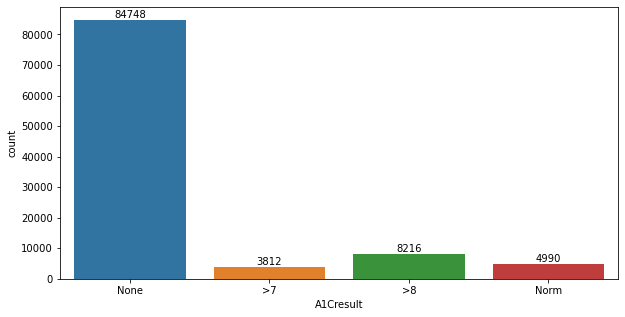

In [611]:
ax = sns.countplot(df['A1Cresult'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

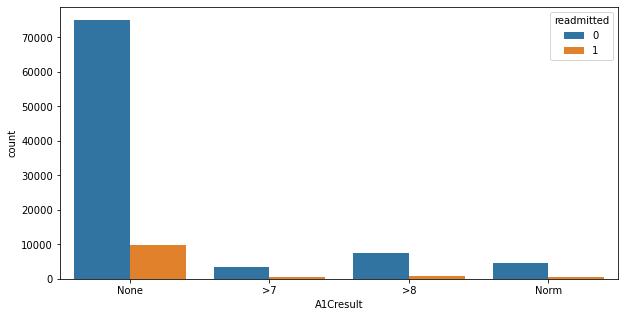

In [612]:
sns.countplot(df['A1Cresult'],hue=df['readmitted'])
plt.show()

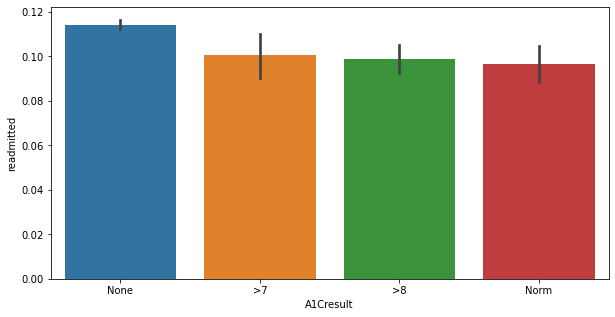

In [613]:
sns.barplot(df['A1Cresult'],df['readmitted'])
plt.show()

For most of the patients AIC test was not conducted

Results were >8 for most of the patients follwed by normal and then >7

Readmission probability was highest for patients with no test conducted, followed by test results >8 and >7

#### Univariate Analysis for 24 medications

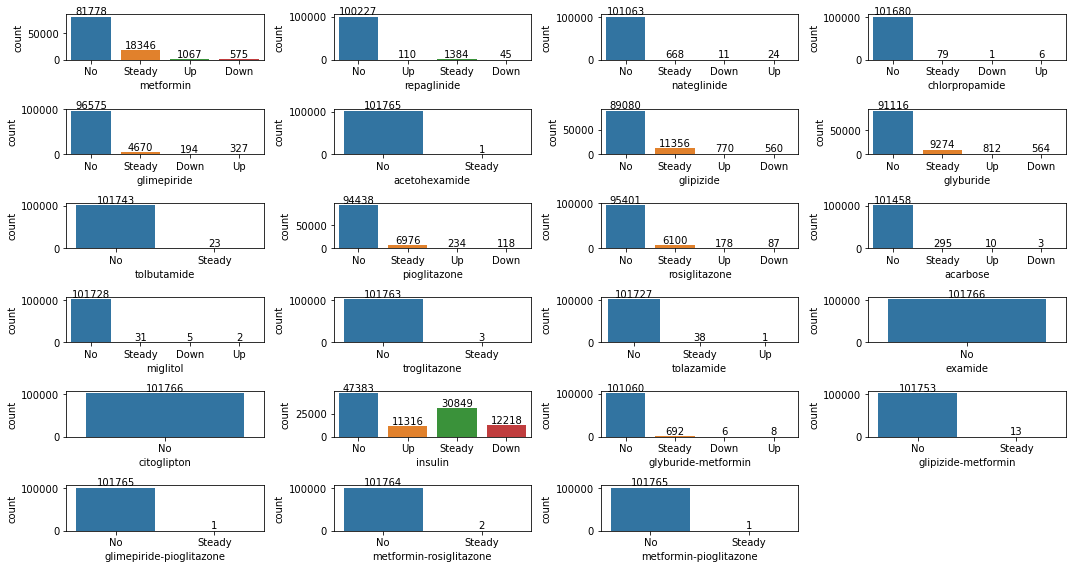

In [614]:
plt.figure(figsize=[15,8])
for i in range(1,24):
    plt.subplot(6,4,i)
    ax = sns.countplot(df.iloc[:,i+18])
    for j in ax.containers:
        ax.bar_label(j,)
plt.tight_layout()
plt.show()

#### Bivariate Analysis for 24 medications

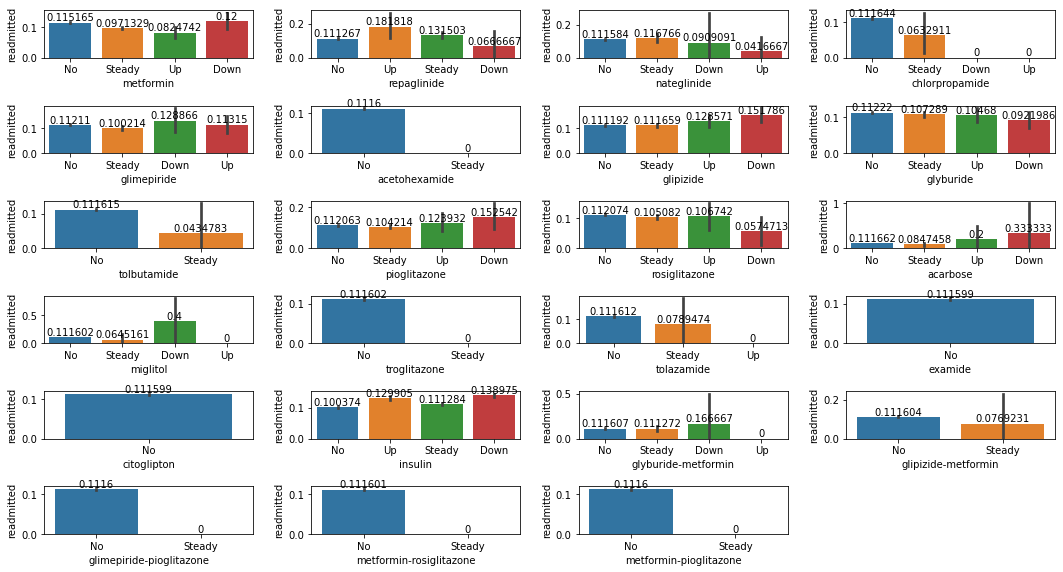

In [615]:
plt.figure(figsize=[15,8])
for i in range(1,24):
    plt.subplot(6,4,i)
    ax = sns.barplot(df.iloc[:,i+18],df['readmitted'])
    for j in ax.containers:
        ax.bar_label(j,)
plt.tight_layout()
plt.show()

#### metformin

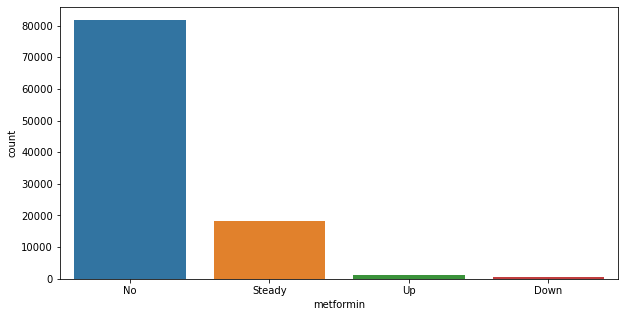

In [616]:
ax = sns.countplot(df['metformin'])
plt.show()

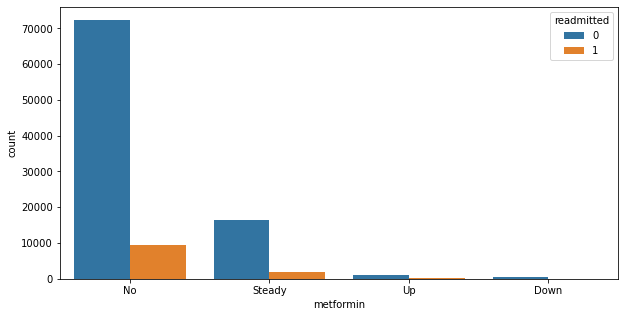

In [617]:
sns.countplot(df['metformin'],hue=df['readmitted'])
plt.show()

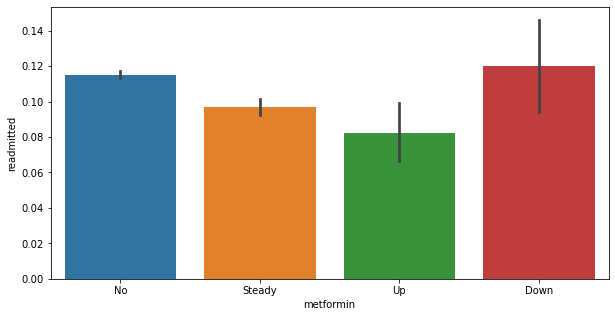

In [618]:
sns.barplot(df['metformin'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients who were not prescribed the drug and whose dosage was decreased

#### repaglinide

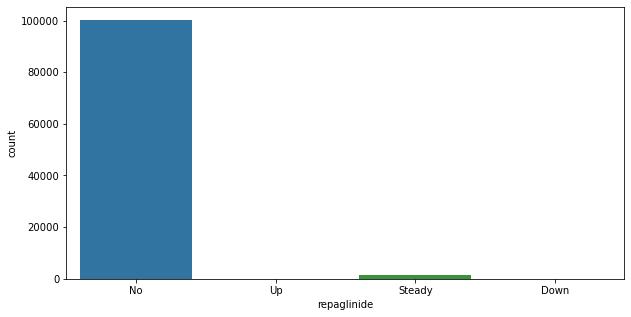

In [619]:
ax = sns.countplot(df['repaglinide'])
plt.show()

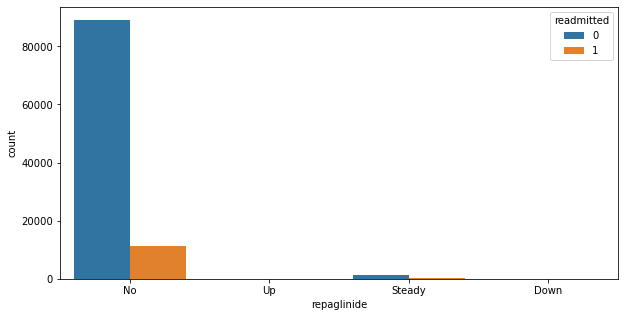

In [620]:
sns.countplot(df['repaglinide'],hue=df['readmitted'])
plt.show()

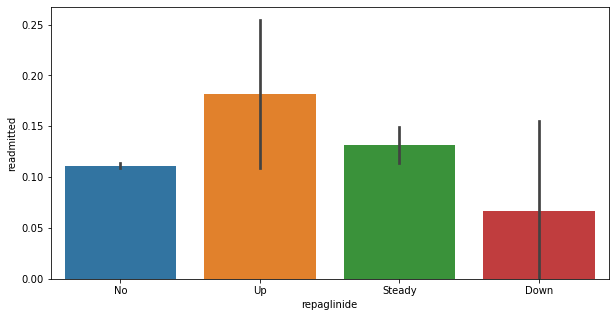

In [621]:
sns.barplot(df['repaglinide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was not changed and whose dosage was decreased

#### nateglinide

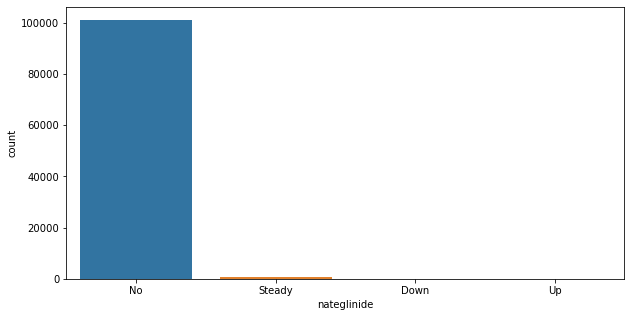

In [622]:
ax = sns.countplot(df['nateglinide'])
plt.show()

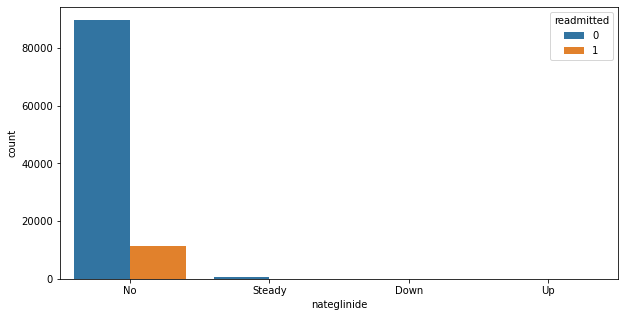

In [623]:
sns.countplot(df['nateglinide'],hue=df['readmitted'])
plt.show()

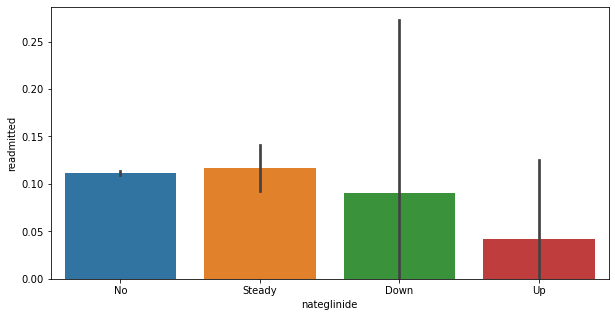

In [624]:
sns.barplot(df['nateglinide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was not changed

#### chlorpropamide

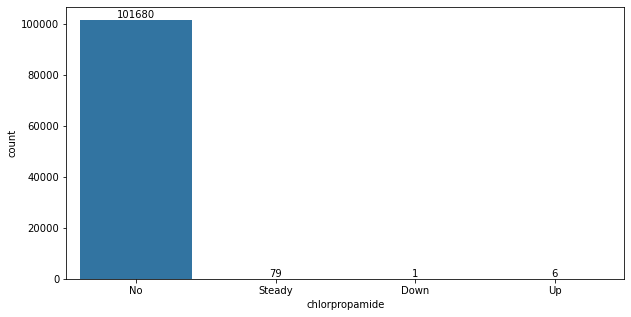

In [625]:
ax = sns.countplot(df['chlorpropamide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

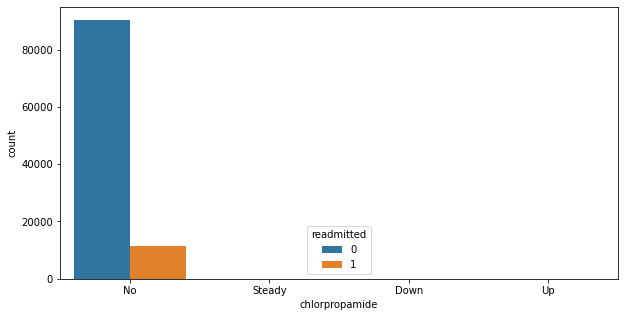

In [626]:
sns.countplot(df['chlorpropamide'],hue=df['readmitted'])
plt.show()

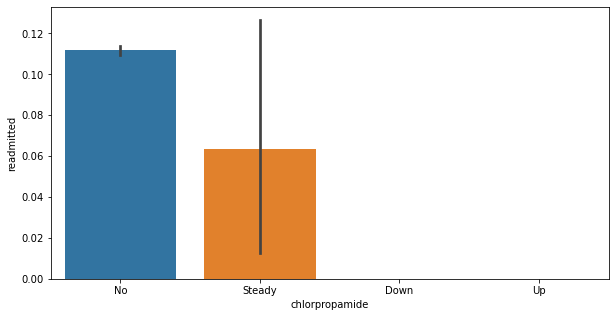

In [627]:
sns.barplot(df['chlorpropamide'],df['readmitted'])
plt.show()

This drug was not prescribed for almost all of the patients

Only for 6 patients the dosage was increased and for 1 patient the dosage was decreased

Readmission probability is higher for patients whose dosage was increased and for who those who were not prescribed

#### glimepiride

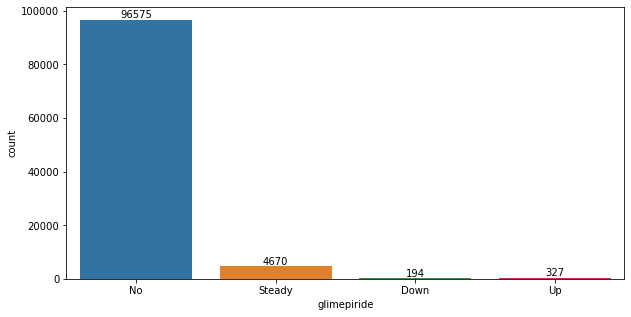

In [628]:
ax = sns.countplot(df['glimepiride'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

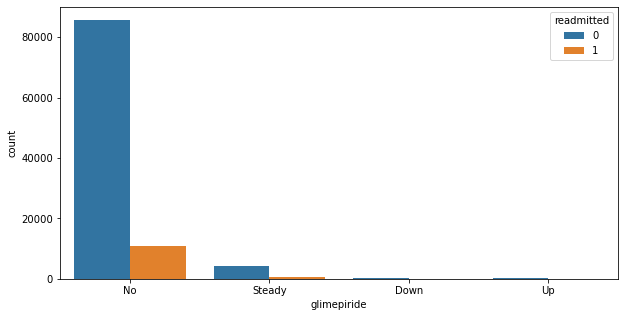

In [629]:
sns.countplot(df['glimepiride'],hue=df['readmitted'])
plt.show()

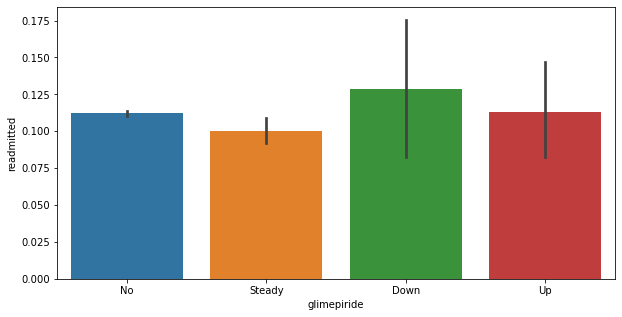

In [630]:
sns.barplot(df['glimepiride'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was decreased and dosage not changed



#### acetohexamide

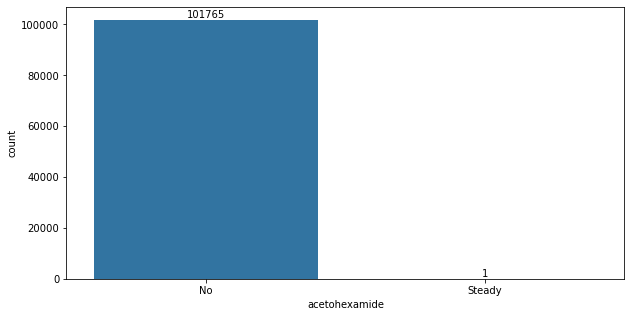

In [631]:
ax = sns.countplot(df['acetohexamide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

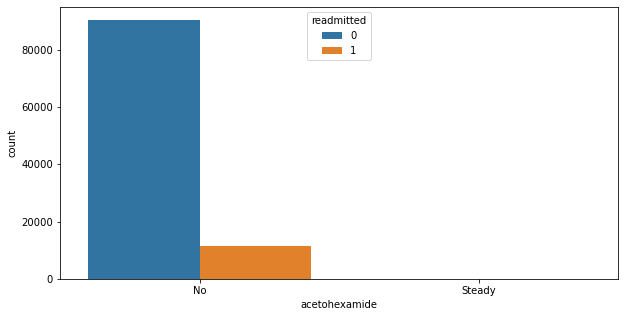

In [632]:
sns.countplot(df['acetohexamide'],hue=df['readmitted'])
plt.show()

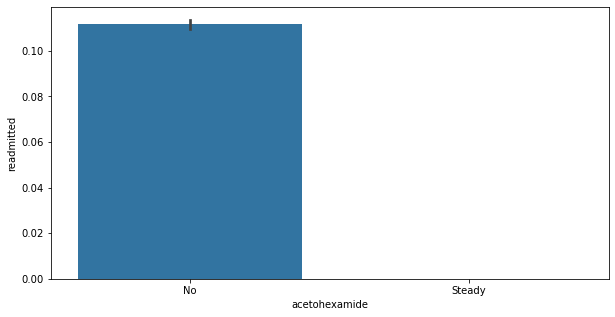

In [633]:
sns.barplot(df['acetohexamide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

There is only one patient for whom dosage was not changed and for the rest the medication was not prescribed

This makes it a redundant column, So dropping it



In [634]:
df.drop('acetohexamide',1,inplace=True)

#### glipizide

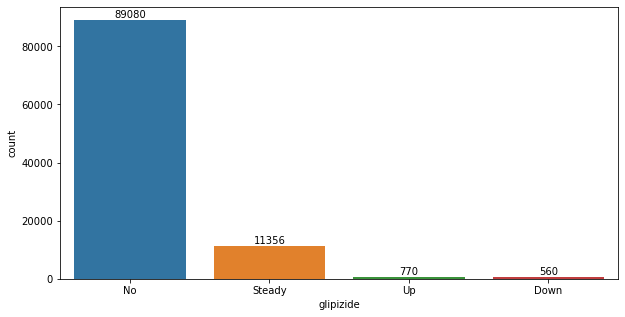

In [635]:
ax = sns.countplot(df['glipizide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

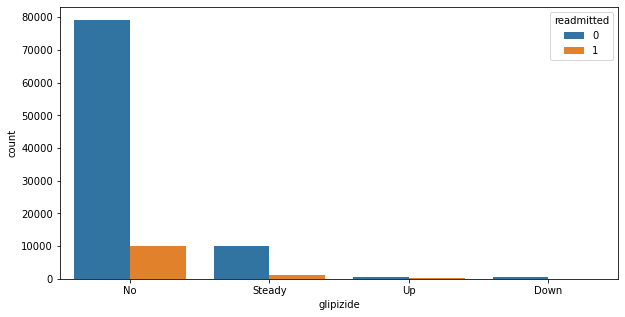

In [636]:
sns.countplot(df['glipizide'],hue=df['readmitted'])
plt.show()

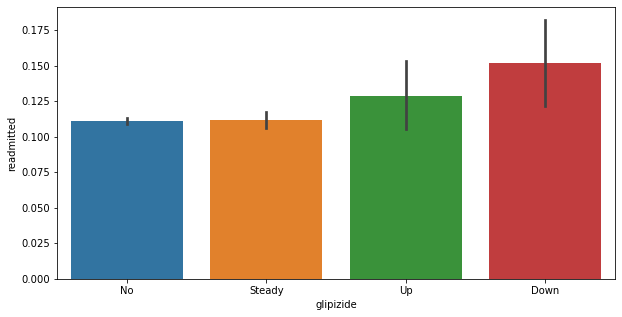

In [637]:
sns.barplot(df['glipizide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was decreased next whose dosage was increased



#### glyburide

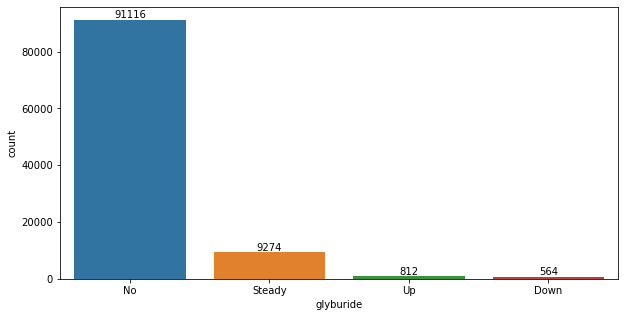

In [638]:
ax = sns.countplot(df['glyburide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

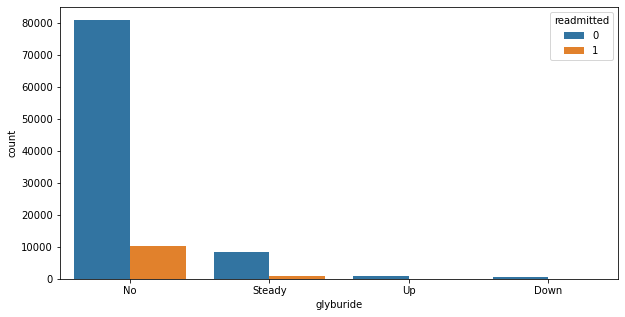

In [639]:
sns.countplot(df['glyburide'],hue=df['readmitted'])
plt.show()

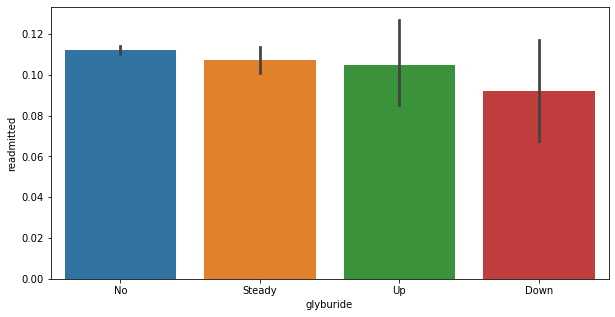

In [640]:
sns.barplot(df['glyburide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was decreased





#### tolbutamide

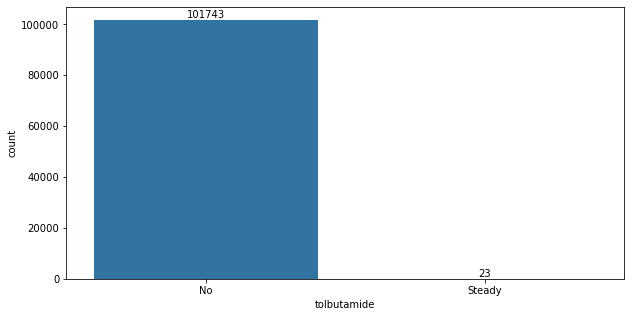

In [641]:
ax = sns.countplot(df['tolbutamide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

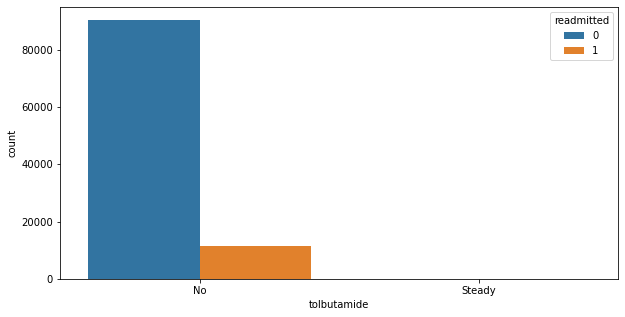

In [642]:
sns.countplot(df['tolbutamide'],hue=df['readmitted'])
plt.show()

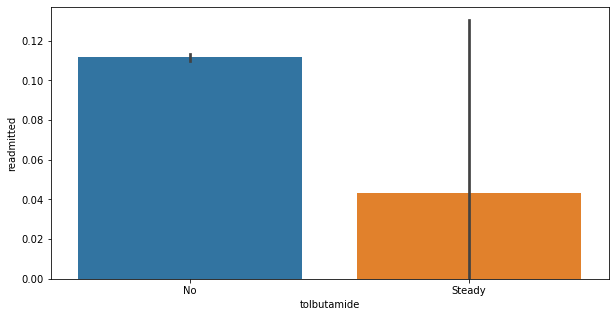

In [643]:
sns.barplot(df['tolbutamide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

There are very less patients for whom the dosage was not changed

#### pioglitazone

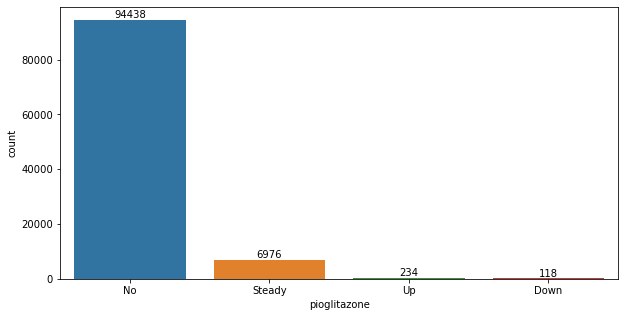

In [644]:
ax = sns.countplot(df['pioglitazone'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

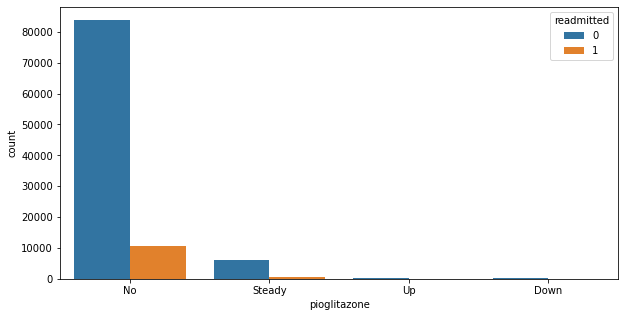

In [645]:
sns.countplot(df['pioglitazone'],hue=df['readmitted'])
plt.show()

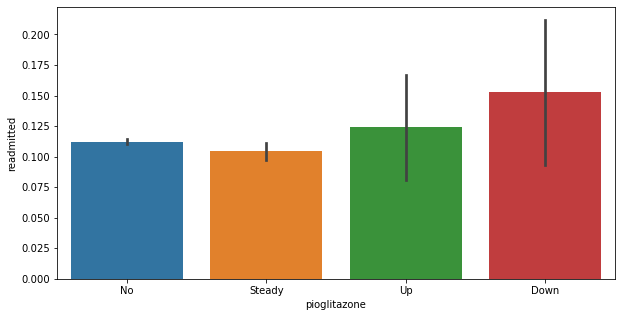

In [646]:
sns.barplot(df['pioglitazone'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was changed

#### rosiglitazone

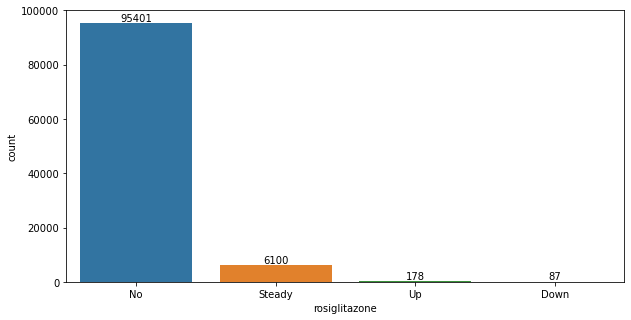

In [647]:
ax = sns.countplot(df['rosiglitazone'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

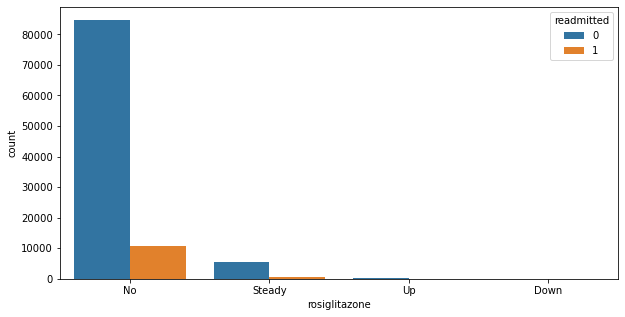

In [648]:
sns.countplot(df['rosiglitazone'],hue=df['readmitted'])
plt.show()

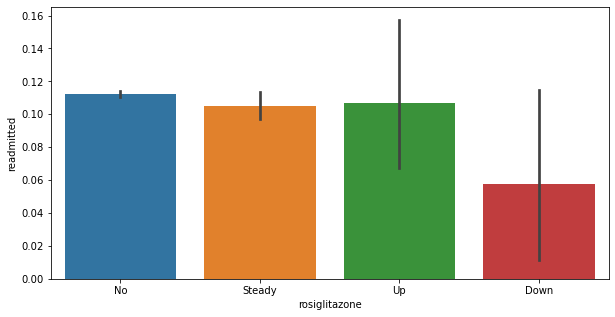

In [649]:
sns.barplot(df['rosiglitazone'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Readmission probability is higher for patients whose dosage was not changed and for those not prescribed

#### acarbose

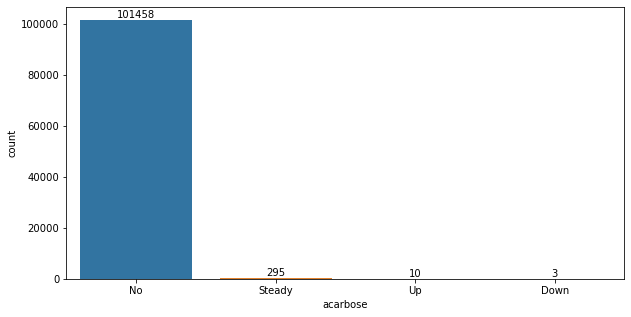

In [650]:
ax = sns.countplot(df['acarbose'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

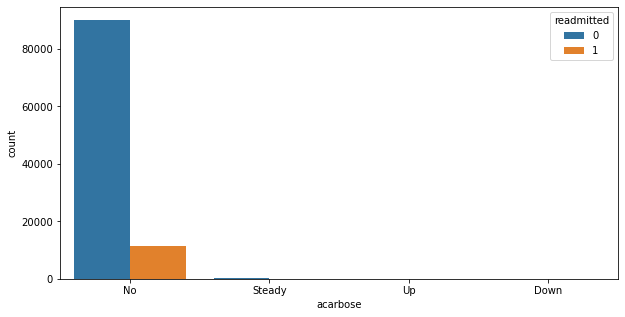

In [651]:
sns.countplot(df['acarbose'],hue=df['readmitted'])
plt.show()

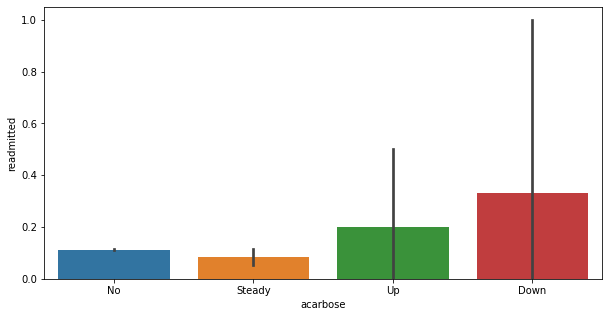

In [652]:
sns.barplot(df['acarbose'],df['readmitted'])
plt.show()

This drug was not prescribed for almost all of the patients

There are very less number of patients for whom the dosage was changed

#### miglitol

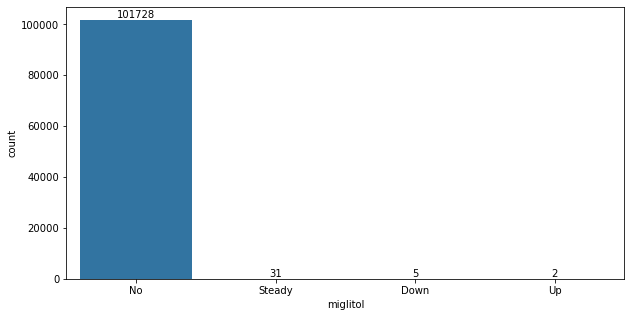

In [653]:
ax = sns.countplot(df['miglitol'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

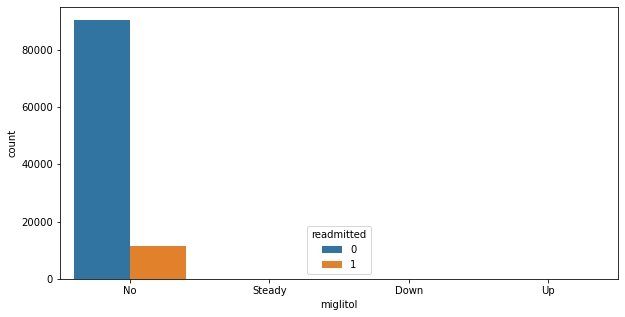

In [654]:
sns.countplot(df['miglitol'],hue=df['readmitted'])
plt.show()

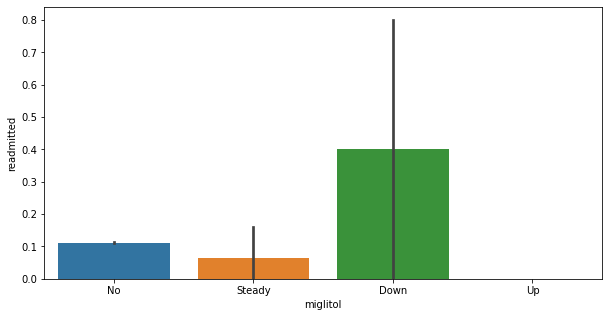

In [655]:
sns.barplot(df['miglitol'],df['readmitted'])
plt.show()

This drug was not prescribed for almost all of the patients



#### troglitazone

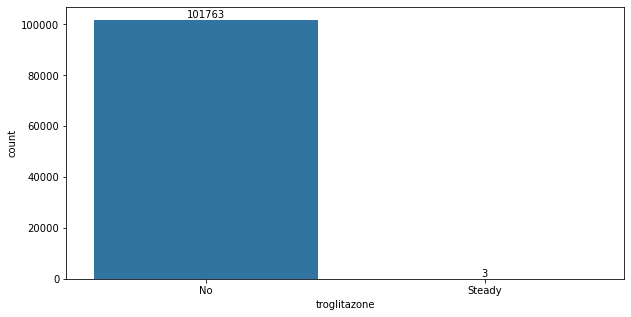

In [656]:
ax = sns.countplot(df['troglitazone'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

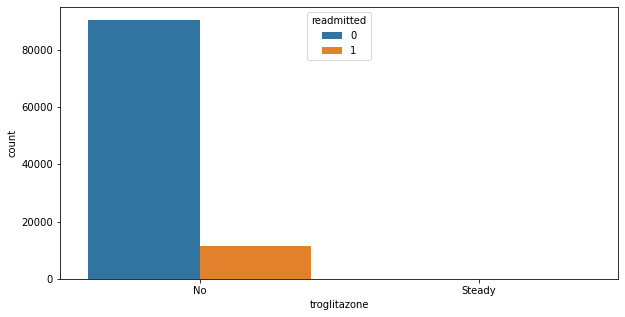

In [657]:
sns.countplot(df['troglitazone'],hue=df['readmitted'])
plt.show()

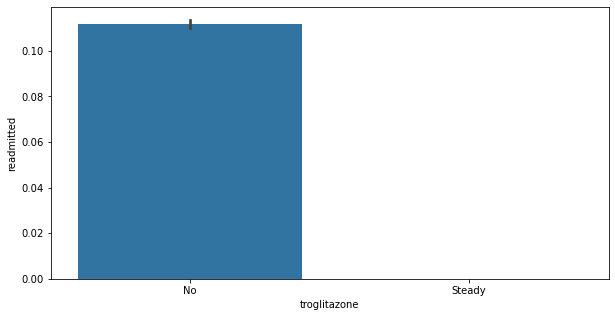

In [658]:
sns.barplot(df['troglitazone'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients

Only for 3 patients the drug was presribed

This makes the feature redundant, so dropping it

In [659]:
df.drop('troglitazone',1,inplace=True)

#### tolazamide
Tolazamide is used to treat high blood sugar levels caused by a type of diabetes mellitus (sugar diabetes) called type 2 diabetes.


https://pubchem.ncbi.nlm.nih.gov/compound/Tolazamide

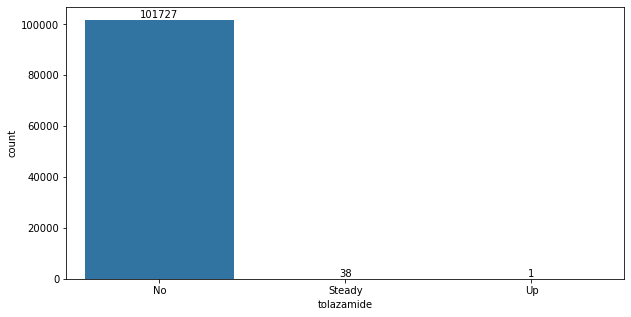

In [660]:
ax = sns.countplot(df['tolazamide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

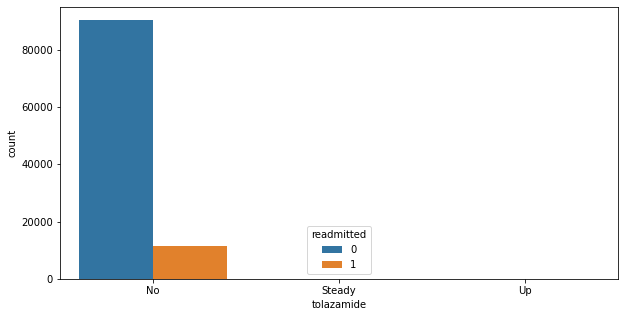

In [661]:
sns.countplot(df['tolazamide'],hue=df['readmitted'])
plt.show()

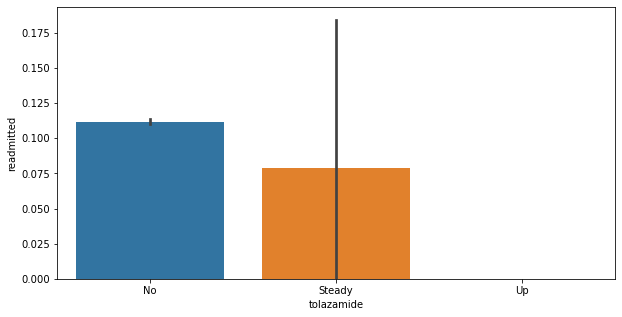

In [662]:
sns.barplot(df['tolazamide'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients.

Only for 39 patients the drug was presribed.

Most of the people with the drug was presribed are readmitted

#### examide


Torsemide is used to help treat fluid retention (edema) and swelling that is caused by congestive heart failure, liver disease, kidney disease.


https://medlineplus.gov/druginfo/meds/a601212.html

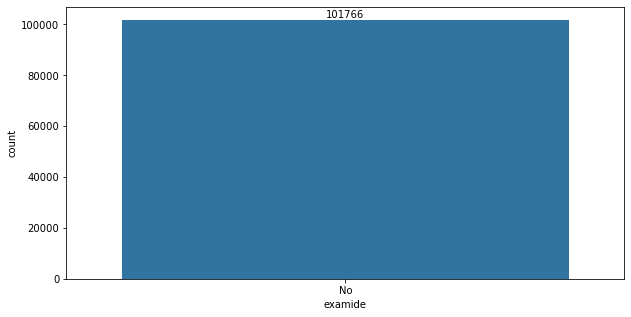

In [663]:
ax = sns.countplot(df['examide'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

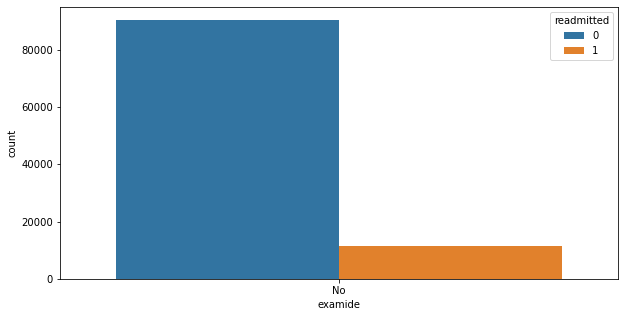

In [664]:
sns.countplot(df['examide'],hue=df['readmitted'])
plt.show()

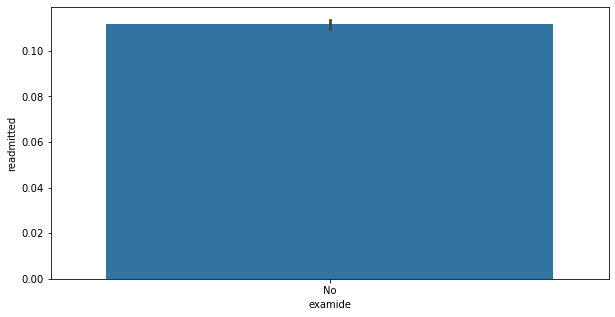

In [665]:
sns.barplot(df['examide'],df['readmitted'])
plt.show()

This drug was not prescribed for the patients

This makes the feature redundant, so dropping it

In [666]:
df.drop('examide',1,inplace=True)

#### citoglipton

Sitagliptin helps to control blood sugar levels by increasing substances in the body that make the pancreas release more insulin. It also signals the liver to stop producing sugar (glucose) when there is too much sugar in the blood.

https://medlineplus.gov/druginfo/meds/a606023.html

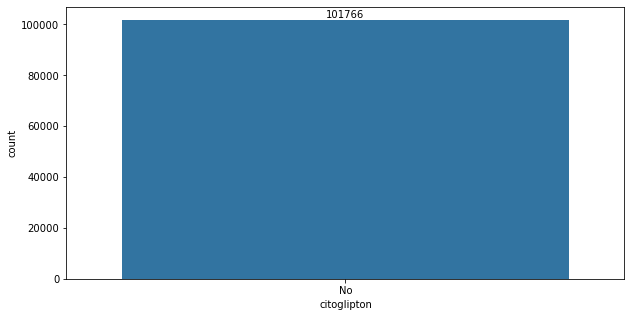

In [667]:
ax = sns.countplot(df['citoglipton'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

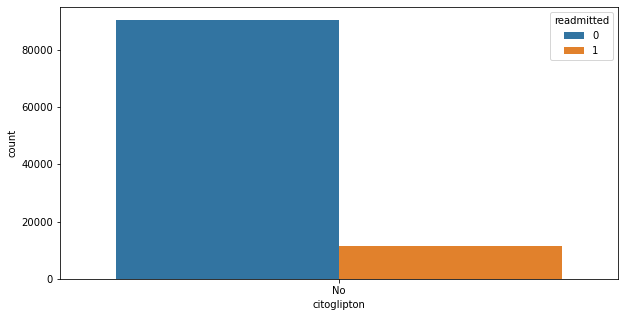

In [668]:
sns.countplot(df['citoglipton'],hue=df['readmitted'])
plt.show()

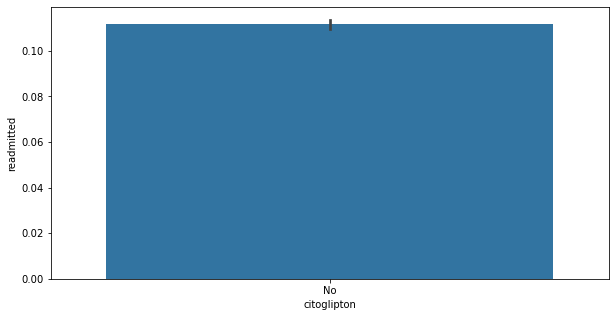

In [669]:
sns.barplot(df['citoglipton'],df['readmitted'])
plt.show()

This drug was not prescribed for the patients

This makes the feature redundant, so dropping it

In [670]:
df.drop('citoglipton',1,inplace=True)

#### insulin

Insulin helps blood sugar enter the body's cells so it can be used for energy. Insulin also signals the liver to store blood sugar for later use. Blood sugar enters cells, and levels in the bloodstream decrease, signaling insulin to decrease too


https://www.cdc.gov/diabetes/basics/insulin-resistance.html

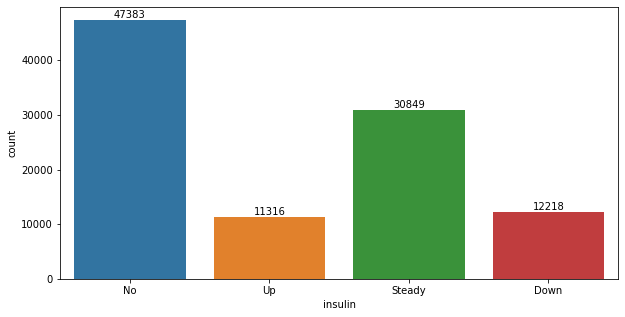

In [671]:
ax = sns.countplot(df['insulin'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

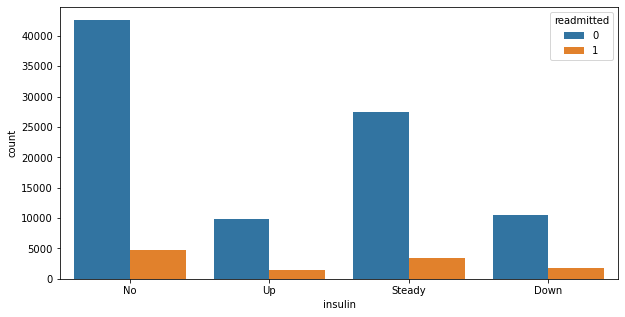

In [672]:
sns.countplot(df['insulin'],hue=df['readmitted'])
plt.show()

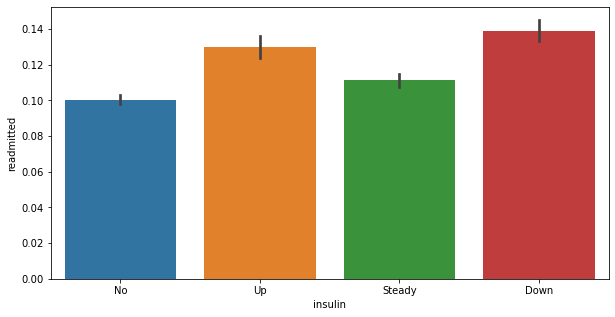

In [673]:
sns.barplot(df['insulin'],df['readmitted'])
plt.show()

This drug was not prescribed for most of the patients next dosage was not changed for many of them

Readmission probability is higher for patients whose dosage was changed

####  Glyburide-metformin


Glyburide and metformin work together to improve your blood sugar levels. Glyburide works by helping your body release more insulin. Metformin works by lowering the amount of sugar in your body.

### https://medlineplus.gov/druginfo/meds/a699055.html

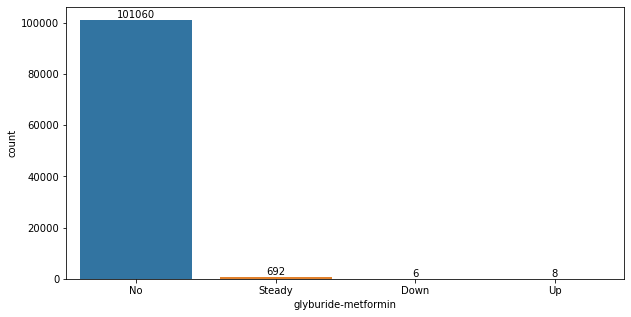

In [674]:
ax = sns.countplot(df['glyburide-metformin'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

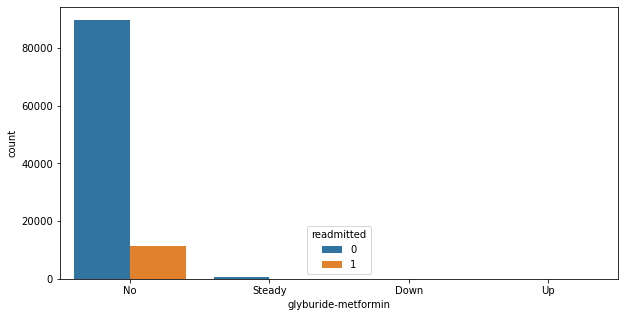

In [675]:
sns.countplot(df['glyburide-metformin'],hue=df['readmitted'])
plt.show()

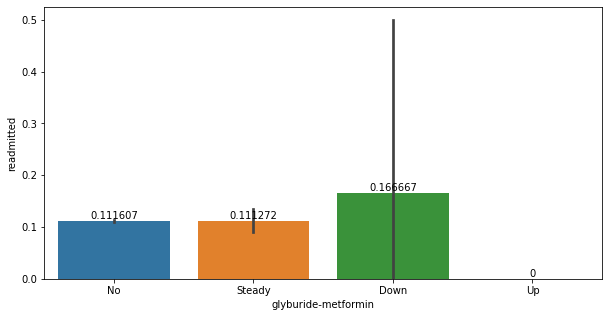

In [676]:
ax = sns.barplot(df['glyburide-metformin'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

This drug was not prescribed for most of the patients.

Readmission probability is higher for patients whose dosage was steady and for whom drug was not prescribed

#### glipizide-metformin

Glipizide and Metformin combination is used to treat high blood sugar levels that are caused by a type of diabetes mellitus or sugar diabetes called type 2 diabetes. 


https://www.drugs.com/mtm/glipizide-and-metformin.html

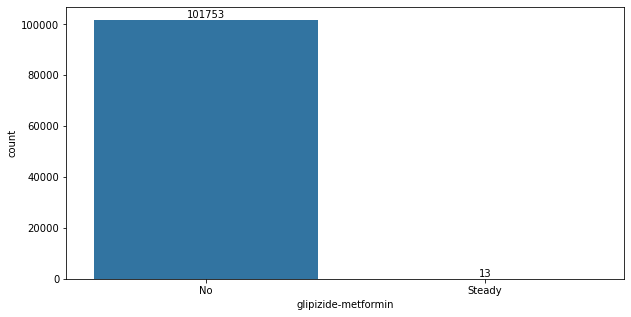

In [677]:
ax = sns.countplot(df['glipizide-metformin'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

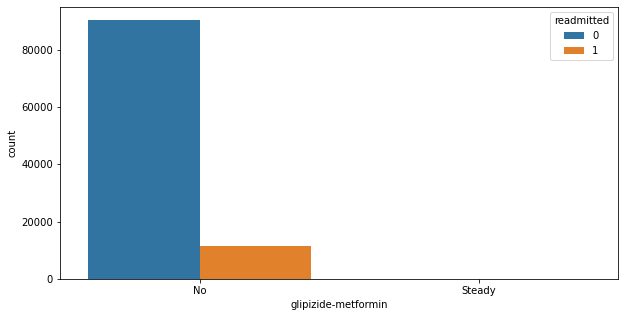

In [678]:
sns.countplot(df['glipizide-metformin'],hue=df['readmitted'])
plt.show()

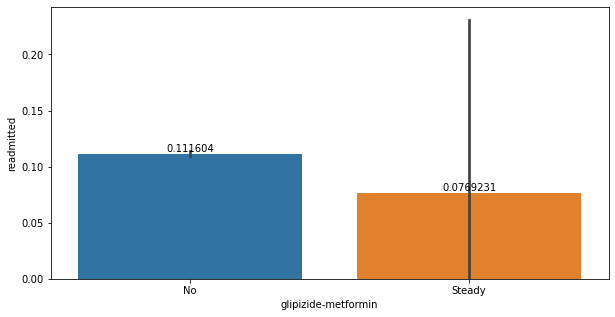

In [679]:
ax = sns.barplot(df['glipizide-metformin'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

This drug was not prescribed for most of the patients.

Only for 13 patients, dosage was steady

This makes the feature redundant, so dropping it

In [680]:
df.drop('glipizide-metformin',1,inplace=True)

####  glimepiride-pioglitazone

used to control high blood sugar in patients with type 2 diabetes.



https://www.drugs.com/mtm/glimepiride-and-pioglitazone.html

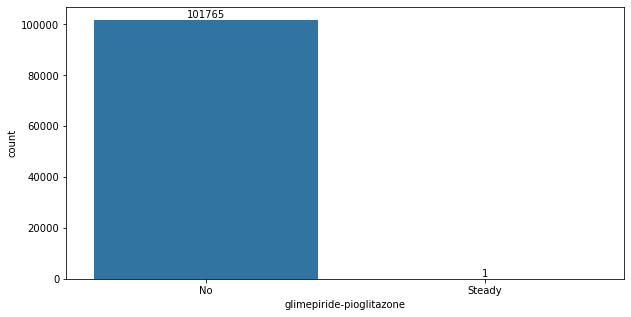

In [681]:
ax = sns.countplot(df['glimepiride-pioglitazone'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

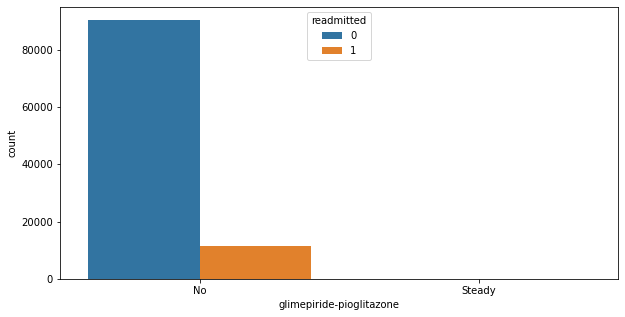

In [682]:
sns.countplot(df['glimepiride-pioglitazone'],hue=df['readmitted'])
plt.show()

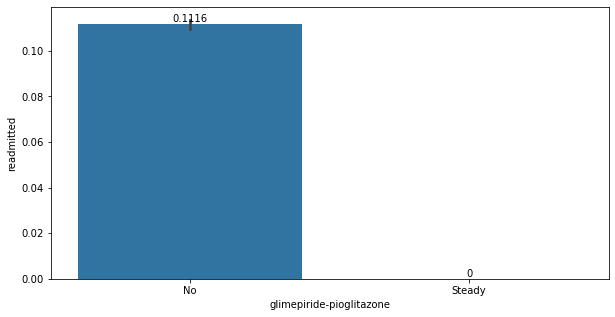

In [683]:
ax = sns.barplot(df['glimepiride-pioglitazone'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

This drug was not prescribed for almost all of the patients.

Only for 1 patient, dosage was steady

This makes the feature redundant, so dropping it

In [684]:
df.drop('glimepiride-pioglitazone',1,inplace=True)

####  metformin-rosiglitazone


Rosiglitazone and metformin combination is used to treat a type of diabetes mellitus called type 2 diabetes.

https://pubmed.ncbi.nlm.nih.gov/16033298/

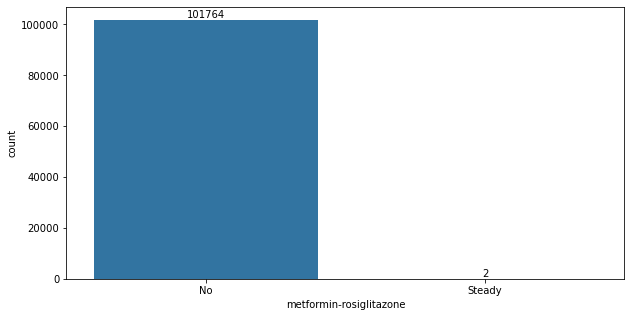

In [685]:
ax = sns.countplot(df['metformin-rosiglitazone'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

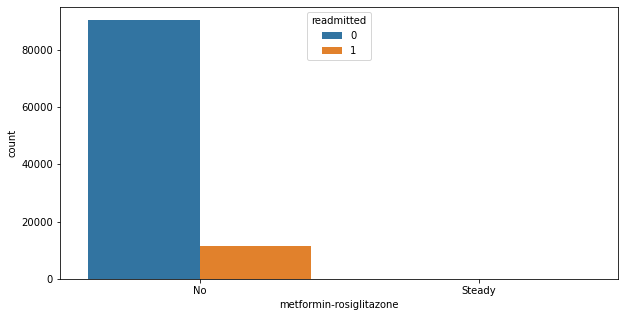

In [686]:
sns.countplot(df['metformin-rosiglitazone'],hue=df['readmitted'])
plt.show()

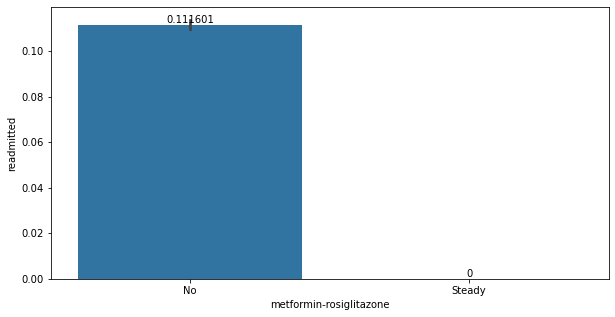

In [687]:
ax = sns.barplot(df['metformin-rosiglitazone'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

This drug was not prescribed for almost all of the patients.

Only for 2 patients, dosage was steady

This makes the feature redundant, so dropping it

#### metformin-pioglitazone

metformin to treat high blood sugar levels caused by type 2 diabetes. Pioglitazone works by helping your body use insulin better.

https://www.drugs.com/mtm/metformin-and-pioglitazone.html

In [688]:
df.drop('metformin-rosiglitazone',1,inplace=True)

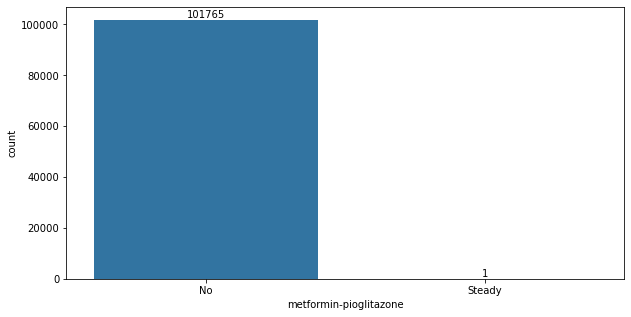

In [689]:
ax = sns.countplot(df['metformin-pioglitazone'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

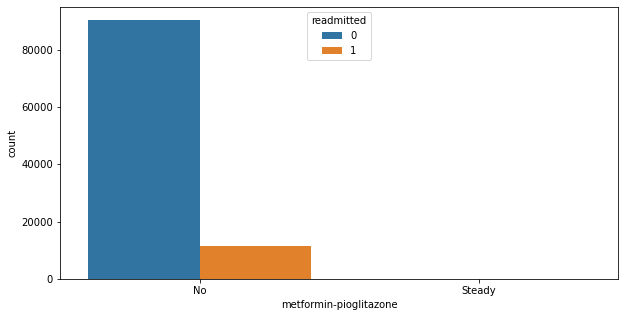

In [690]:
sns.countplot(df['metformin-pioglitazone'],hue=df['readmitted'])
plt.show()

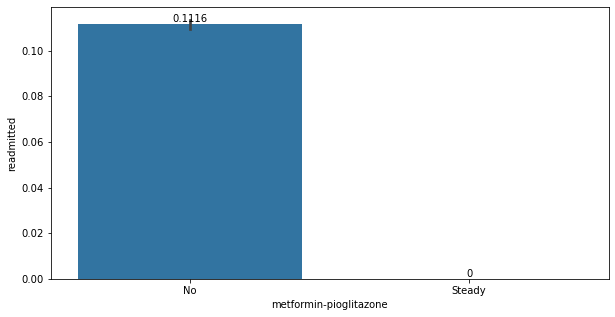

In [691]:
ax = sns.barplot(df['metformin-pioglitazone'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

This drug was not prescribed for almost all of the patients.

Only for 1 patient, dosage was steady

This makes the feature redundant, so dropping it

#### change

This column tells if the medication is changed or not 

NO: No Change
CH: Medication Changed

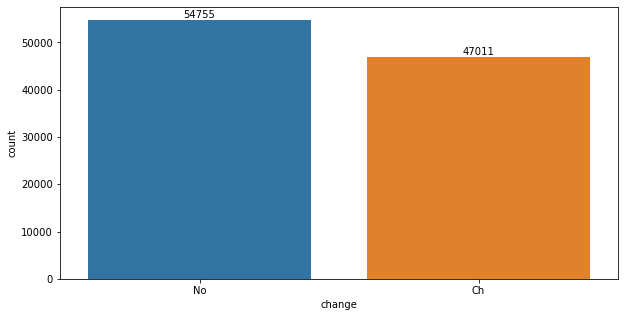

In [692]:
ax = sns.countplot(df['change'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

In [693]:
df.drop('metformin-pioglitazone',1,inplace=True)

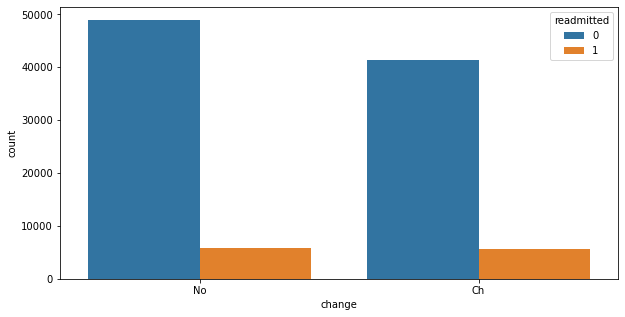

In [694]:
sns.countplot(df['change'],hue=df['readmitted'])
plt.show()

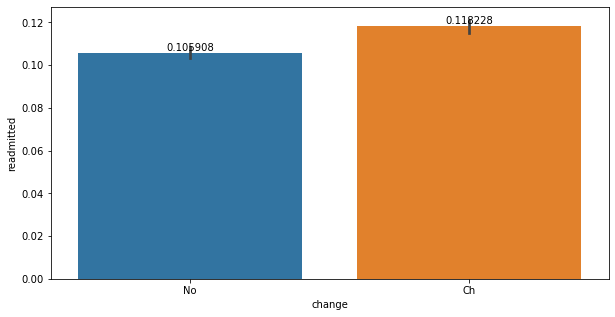

In [695]:
ax = sns.barplot(df['change'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

The number of patients for whom the medication is not changed is higher than those whose medication was not changed

Readmission probability is almost same for both, but slightly higher for the ones whose medication is changed

#### Diabetes Med

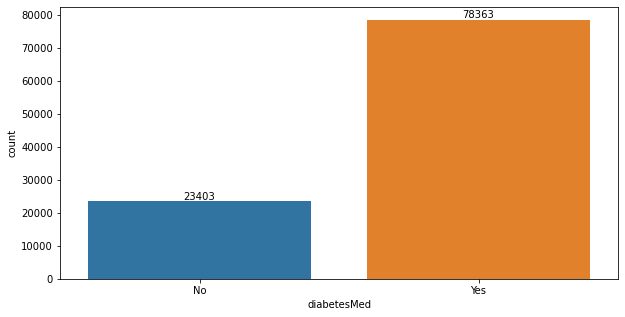

In [696]:
ax = sns.countplot(df['diabetesMed'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

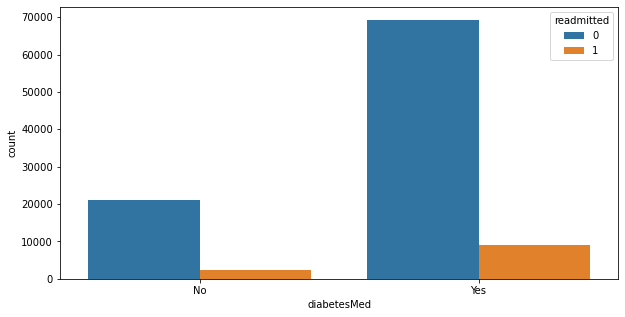

In [697]:
sns.countplot(df['diabetesMed'],hue=df['readmitted'])
plt.show()

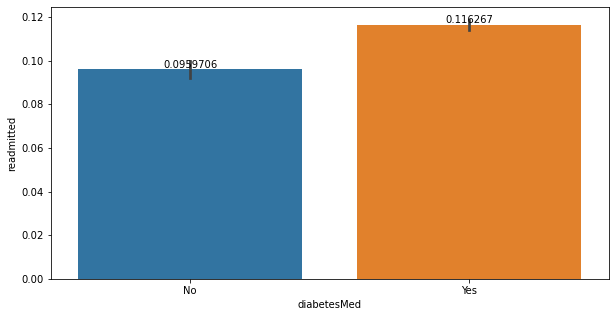

In [698]:
 ax = sns.barplot(df['diabetesMed'],df['readmitted'])
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

The patients for whom diabetes medication was prescribed are higher in count


### Null Value treatment

In [699]:
df.isnull().sum()

race                         2273
gender                          0
age                             0
admission_type_id           10396
discharge_disposition_id        0
admission_source_id          6942
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose      

In [700]:
df.shape

(101766, 37)

In [701]:
df['admission_type_id'].mode()

0    Emergency
dtype: object

In [702]:
df['race'].fillna(df['race'].mode()[0],inplace=True)
df['admission_source_id'].fillna(df['admission_source_id'].mode()[0],inplace=True)
df['admission_type_id'].fillna(df['admission_type_id'].mode()[0],inplace=True)

In [703]:
df["race"] = df['race'].replace(["Asian","Hispanic"],"Other")

In [704]:
df.describe(include='O')

,race,gender,age,admission_type_id,admission_source_id,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,3,3,10,4,3,9,9,9,4,4,4,4,4,4,4,4,4,2,4,4,4,4,3,4,4,2,2
top,Caucasian,Female,[70-80),Emergency,Emergency,Circulatory,Circulatory,Other,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes
freq,78372,54708,26068,82866,64436,30437,31881,30618,96420,84748,81778,100227,101063,101680,96575,89080,91116,101743,94438,95401,101458,101728,101727,47383,101060,54755,78363


In [705]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),Emergency,25,Referral,1,41,0,1,0,0,0,Diabetes,Other,Other,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),Emergency,1,Emergency,3,59,0,18,0,0,0,Other,Diabetes,Other,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),Emergency,1,Emergency,2,11,5,13,2,0,1,Other,Diabetes,Other,6,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),Emergency,1,Emergency,2,44,1,16,0,0,0,Other,Diabetes,Circulatory,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,0
4,Caucasian,Male,[40-50),Emergency,1,Emergency,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,Ch,Yes,0


In [706]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [707]:
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),Emergency,25,Referral,1,41,0,1,0,0,0,Diabetes,Other,Other,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),Emergency,1,Emergency,3,59,0,18,0,0,0,Other,Diabetes,Other,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),Emergency,1,Emergency,2,11,5,13,2,0,1,Other,Diabetes,Other,6,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),Emergency,1,Emergency,2,44,1,16,0,0,0,Other,Diabetes,Circulatory,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,Ch,Yes,0
4,Caucasian,Male,[40-50),Emergency,1,Emergency,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,Ch,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),Emergency,3,Emergency,3,51,0,16,0,0,0,Diabetes,Other,Circulatory,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,Ch,Yes,0
101762,AfricanAmerican,Female,[80-90),Emergency,4,Other,5,33,3,18,0,0,1,Digestive,Other,Digestive,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,Yes,0
101763,Caucasian,Male,[70-80),Emergency,1,Emergency,1,53,0,9,1,0,0,Other,Genitourinary,Other,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,Ch,Yes,0
101764,Caucasian,Female,[80-90),Emergency,3,Emergency,10,45,2,21,0,0,1,Injury,Other,Injury,9,None,None,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,Up,No,Ch,Yes,0


In [708]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [709]:
df = pd.get_dummies(data = df, columns= ['race', 'gender', 'admission_type_id', 'admission_source_id','max_glu_serum',
                                         'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                         'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                                         'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
                                         'glyburide-metformin', 'change', 'diabetesMed' ], drop_first=True)

In [710]:
df

,age,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,readmitted,race_Caucasian,race_Other,gender_Male,gender_Unknown/Invalid,admission_type_id_Emergency,admission_type_id_New Born,admission_type_id_Trauma Center,admission_source_id_Other,admission_source_id_Referral,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes
0,[0-10),25,1,41,0,1,0,0,0,Diabetes,Other,Other,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
1,[10-20),1,3,59,0,18,0,0,0,Other,Diabetes,Other,9,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
2,[20-30),1,2,11,5,13,2,0,1,Other,Diabetes,Other,6,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1
3,[30-40),1,2,44,1,16,0,0,0,Other,Diabetes,Circulatory,7,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
4,[40-50),1,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,[70-80),3,3,51,0,16,0,0,0,Diabetes,Other,Circulatory,9,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
101762,[80-90),4,5,33,3,18,0,0,1,Digestive,Other,Digestive,9,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1
101763,[70-80),1,1,53,0,9,1,0,0,Other,Genitourinary,Other,13,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
101764,[80-90),3,10,45,2,21,0,0,1,Injury,Other,Injury,9,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1


In [711]:
x = df.drop('readmitted',1)
y = df['readmitted']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=123)

In [712]:
xtrain.sort_index(inplace=True)
xtest.sort_index(inplace=True)

In [713]:
xtrain.head()

,age,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,race_Caucasian,race_Other,gender_Male,gender_Unknown/Invalid,admission_type_id_Emergency,admission_type_id_New Born,admission_type_id_Trauma Center,admission_source_id_Other,admission_source_id_Referral,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes
0,[0-10),25,1,41,0,1,0,0,0,Diabetes,Other,Other,1,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
1,[10-20),1,3,59,0,18,0,0,0,Other,Diabetes,Other,9,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
3,[30-40),1,2,44,1,16,0,0,0,Other,Diabetes,Circulatory,7,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
4,[40-50),1,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
5,[50-60),1,3,31,6,16,0,0,0,Circulatory,Circulatory,Diabetes,9,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1


In [714]:
SS = StandardScaler()
xtrain.iloc[:,[2,3,4,5,6,7,8,12]] = SS.fit_transform(xtrain.iloc[:,[2,3,4,5,6,7,8,12]])
xtest.iloc[:,[2,3,4,5,6,7,8,12]] = SS.transform(xtest.iloc[:,[2,3,4,5,6,7,8,12]])

In [715]:
xtrain.sort_index(inplace=True)
xtest.sort_index(inplace=True)

In [716]:
xtrain

,age,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,race_Caucasian,race_Other,gender_Male,gender_Unknown/Invalid,admission_type_id_Emergency,admission_type_id_New Born,admission_type_id_Trauma Center,admission_source_id_Other,admission_source_id_Referral,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes
0,[0-10),25,-1.137389,-0.109750,-0.788221,-1.847975,-0.290927,-0.217369,-0.500389,Diabetes,Other,Other,-3.325205,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
1,[10-20),1,-0.468697,0.805372,-0.788221,0.238623,-0.290927,-0.217369,-0.500389,Other,Diabetes,Other,0.815927,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
3,[30-40),1,-0.803043,0.042770,-0.203206,-0.006859,-0.290927,-0.217369,-0.500389,Other,Diabetes,Circulatory,-0.219356,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
4,[40-50),1,-1.137389,0.398651,-0.788221,-0.988787,-0.290927,-0.217369,-0.500389,Neoplasms,Neoplasms,Diabetes,-1.254639,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
5,[50-60),1,-0.468697,-0.618151,2.721866,-0.006859,-0.290927,-0.217369,-0.500389,Circulatory,Circulatory,Diabetes,0.815927,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101759,[80-90),1,-1.137389,-2.143355,-0.788221,-0.129600,2.072181,-0.217369,-0.500389,Circulatory,Other,Diabetes,-0.219356,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
101760,[60-70),1,0.534340,0.093611,-0.203206,1.097810,2.072181,0.888352,1.076470,Other,Circulatory,Circulatory,0.815927,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
101762,[80-90),4,0.199995,-0.516471,0.966823,0.238623,-0.290927,-0.217369,0.288041,Digestive,Other,Digestive,0.815927,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1
101763,[70-80),1,-1.137389,0.500332,-0.788221,-0.866046,0.496776,-0.217369,-0.500389,Other,Genitourinary,Other,2.886493,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [717]:
xtrain.iloc[:,[0,1,9,10,11]]

,age,discharge_disposition_id,diag_1,diag_2,diag_3
0,[0-10),25,Diabetes,Other,Other
1,[10-20),1,Other,Diabetes,Other
3,[30-40),1,Other,Diabetes,Circulatory
4,[40-50),1,Neoplasms,Neoplasms,Diabetes
5,[50-60),1,Circulatory,Circulatory,Diabetes
...,...,...,...,...,...
101759,[80-90),1,Circulatory,Other,Diabetes
101760,[60-70),1,Other,Circulatory,Circulatory
101762,[80-90),4,Digestive,Other,Digestive
101763,[70-80),1,Other,Genitourinary,Other


In [718]:
xtrain.dtypes.head()

age                          object
discharge_disposition_id      int64
time_in_hospital            float64
num_lab_procedures          float64
num_procedures              float64
dtype: object

In [719]:
ytrain

38669    1
33937    0
24073    0
48059    0
26297    0
        ..
63206    0
61404    0
17730    0
28030    0
15725    0
Name: readmitted, Length: 71236, dtype: int64

In [720]:
clf = WOE()

In [721]:
clf.fit(xtrain.iloc[:,[0,1,9,10,11]],ytrain)

WOE(mono_custom_binning={'discharge_disposition_id': array([ 1.,  3., 28.])},
    woe_bins={'age': {'[0-10)': -1.9268196570315401,
                      '[10-20)': -0.7781687187382516,
                      '[20-30)': 0.3454093159476061,
                      '[30-40)': -0.01576271740427026,
                      '[40-50)': -0.05798539417053427,
                      '[50-60)': -0.14050695769530783,
                      '[60-70)': -0.00011493878235875114,
                      '[70-80)': 0.039066744600645624,
                      '[80-90)': 0.094...
                         'Digestive': 0.07962953623410363,
                         'Genitourinary': 0.2020633410637286,
                         'Injury': 0.07588809041690614,
                         'Muscoloskeletal': -0.08865250437248103,
                         'Neoplasms': 0.22256838596076545,
                         'Other': -0.025294531776325065,
                         'Respiratory': 0.09027011268739044},
              'discha

In [722]:
xtrain.iloc[:,[0,1,9,10,11]] = clf.transform(xtrain.iloc[:,[0,1,9,10,11]])
xtest.iloc[:,[0,1,9,10,11]] = clf.transform(xtest.iloc[:,[0,1,9,10,11]])

In [723]:
xtrain.shape

(71236, 72)

In [724]:
xtest.shape

(30530, 72)

In [725]:
xtrain


,age,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,race_Caucasian,race_Other,gender_Male,gender_Unknown/Invalid,admission_type_id_Emergency,admission_type_id_New Born,admission_type_id_Trauma Center,admission_source_id_Other,admission_source_id_Referral,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_No,diabetesMed_Yes
0,-1.926820,0.191729,-1.137389,-0.109750,-0.788221,-1.847975,-0.290927,-0.217369,-0.500389,0.162352,0.012326,-0.025295,-3.325205,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
1,-0.778169,-0.070885,-0.468697,0.805372,-0.788221,0.238623,-0.290927,-0.217369,-0.500389,0.041599,-0.055951,-0.025295,0.815927,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
3,-0.015763,-0.070885,-0.803043,0.042770,-0.203206,-0.006859,-0.290927,-0.217369,-0.500389,0.041599,-0.055951,-0.038091,-0.219356,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
4,-0.057985,-0.070885,-1.137389,0.398651,-0.788221,-0.988787,-0.290927,-0.217369,-0.500389,-0.143283,0.351759,-0.059676,-1.254639,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
5,-0.140507,-0.070885,-0.468697,-0.618151,2.721866,-0.006859,-0.290927,-0.217369,-0.500389,0.033453,-0.011652,-0.059676,0.815927,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101759,0.094788,-0.070885,-1.137389,-2.143355,-0.788221,-0.129600,2.072181,-0.217369,-0.500389,0.033453,0.012326,-0.059676,-0.219356,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
101760,-0.000115,-0.070885,0.534340,0.093611,-0.203206,1.097810,2.072181,0.888352,1.076470,0.041599,-0.011652,-0.038091,0.815927,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
101762,0.094788,0.191729,0.199995,-0.516471,0.966823,0.238623,-0.290927,-0.217369,0.288041,-0.034901,0.012326,0.079630,0.815927,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1
101763,0.039067,-0.070885,-1.137389,0.500332,-0.788221,-0.866046,0.496776,-0.217369,-0.500389,0.041599,0.054924,-0.025295,2.886493,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


### Base Model

In [726]:
kn = KNeighborsClassifier()
kn.fit(xtrain,ytrain)
ypred = kn.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     27145
           1       0.11      0.01      0.02      3385

    accuracy                           0.88     30530
   macro avg       0.50      0.50      0.48     30530
weighted avg       0.80      0.88      0.83     30530



In [727]:
ypred = kn.predict(xtrain)
print(classification_report(ytrain,ypred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     63264
           1       0.62      0.06      0.12      7972

    accuracy                           0.89     71236
   macro avg       0.76      0.53      0.53     71236
weighted avg       0.86      0.89      0.85     71236



In [728]:
accuracy_score(ytest,ypred)

ValueError: Found input variables with inconsistent numbers of samples: [30530, 71236]

In [ ]:
from sklearn.metrics import precision_score
print(precision_score(ytest,ypred))

In [ ]:
cm = confusion_matrix(ytest, ypred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd',cbar=False,  linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob),4)))
                               
# plot the grid
plt.grid(True)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)
ypred = dt.predict(xtest)
print(classification_report(ytest,ypred))

In [ ]:
lr = LogisticRegression()
lr.fit(xtrain,ytrain)
ypred = lr.predict(xtest)
print(classification_report(ytest,ypred))

PCA
important features

In [ ]:
df

In [ ]:
df

In [ ]:
df1=pd.read_csv("diabetic_data.csv")
df1.head()

In [ ]:
df1[df1['patient_nbr'] == 88785891]